# Advanced Analysis

* [ ] XGBRegreesor trained without `early_stopping` `predict()` using all trees???
* [ ] Add hour-aware (intra-day) analysis
    * Maybe can build hour model???

In [1]:
import gc
import random
import warnings
import pickle
from tqdm.notebook import tqdm
from collections import defaultdict
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, Optional, List, Tuple
warnings.simplefilter("ignore")

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from polars.testing import assert_series_equal
from sklearn.metrics import mean_absolute_error as mae

from cv.build import TSCV
from metadata import *

pd.options.display.max_rows = None
pd.options.display.max_columns = None

OUTPUT_PATH = Path("./output")
sns.set_style("dark")

## Re-Derive CV Scores

In [2]:
p_oof = pd.read_csv("./legacy/yp_oof_final.csv")
cc_oof = pd.read_csv("./legacy/ycc_oof_final.csv")
cb_oof = pd.read_csv("./legacy/ycb_oof_final.csv")

In [3]:
p_oof.shape, cc_oof.shape, cb_oof.shape

In [8]:
y = pd.concat([cb_oof, cc_oof, p_oof], ignore_index=True, join="outer")
y.head()

In [9]:
y["sub1"] = 0

p_mask = y["is_consumption"] == 0
y.loc[p_mask, "sub1"] = y.loc[p_mask, "oof0_dcap_xl"]
cc_mask = (y["is_consumption"] == 1) & (y["is_business"] == 0)
y.loc[cc_mask, "sub1"] = y.loc[cc_mask, "oof0_div_xl"]
cb_mask = (y["is_consumption"] == 1) & (y["is_business"] == 1)
y.loc[cb_mask, "sub1"] = y.loc[cb_mask, "oof0_ens_xl"]
y["sub1"].isna().sum()

In [20]:
prfs = []
for fold in range(3):
    y_fold = y[y[f"fold{fold}_eval"] == 1]
    prfs.append(mae(y_fold["target"], y_fold["sub1"]))

In [21]:
np.mean(prfs)

In [12]:
mae(y["target"], y["sub1"])

In [13]:
y["sub2"] = 0

p_mask = y["is_consumption"] == 0
y.loc[p_mask, "sub2"] = y.loc[p_mask, "oof0_dcap_xl"]
cc_mask = (y["is_consumption"] == 1) & (y["is_business"] == 0)
y.loc[cc_mask, "sub2"] = y.loc[cc_mask, "oof0_div_xl"]
cb_mask = (y["is_consumption"] == 1) & (y["is_business"] == 1)
y.loc[cb_mask, "sub2"] = y.loc[cb_mask, "oof0_ens3_xl"]
y["sub2"].isna().sum()

In [22]:
prfs = []
for fold in range(3):
    y_fold = y[y[f"fold{fold}_eval"] == 1]
    prfs.append(mae(y_fold["target"], y_fold["sub2"]))

In [23]:
np.mean(prfs)

In [ ]:
mae(y["target"], y["sub2"])

#### **Submission Quick Check**

In [2]:
sub_old = pd.read_csv("submission(14).csv")
sub_new = pd.read_csv("submission(16).csv")

fig, ax = plt.subplots(figsize=(24, 6))
ax2 = ax.twinx()
ax.plot(sub_old["target"], "g-", label="old sub")
ax.plot(sub_new["target"], "r-", label="new sub")
ax2.plot(sub_old["target"] - sub_new["target"], "b-")
plt.show()

In [ ]:
train = pl.read_csv("./data/raw/train.csv", try_parse_dates=True)
train = train.filter(pl.col("datetime") >= datetime(2023, 5, 28, 0)).rename({"target": "y"})
train = train.join(pl.from_pandas(sub_old), on="row_id", how="left").rename({"target": "pred_old"})
train = train.join(pl.from_pandas(sub_new), on="row_id", how="left").rename({"target": "pred_new"})
# train = train.join(pl.from_pandas(sub_bad), on="row_id", how="left").rename({"target": "pred_bad"})
train.head()

In [10]:
# Some missing fwth for hour 23, but 23 tends to have lower MAE
fwth = pl.read_csv("./data/raw/forecast_weather.csv", try_parse_dates=True)
fwth_filt = fwth.filter((pl.col("hours_ahead") >= 22) & (pl.col("hours_ahead") <= 45))
tmp = fwth_filt.group_by("data_block_id").agg(pl.col("forecast_datetime").max().alias("max_dt"))
tmp = tmp.with_columns(pl.col("max_dt").dt.hour().alias("max_hour"))
tmp["max_hour"].value_counts()

In [ ]:
# Loacl & Kaggle alignment test
df_local = pl.read_parquet("./data/processed/base_feats.parquet")
test_local = (
    df_local
    .filter(pl.col("datetime") >= datetime(2023, 5, 28, 0))
    .select(test_last_4_dts.columns)
)
test_last_4_dts = pl.read_csv("X_last_4_dt.csv", try_parse_dates=True)

fwth_feats = [c for c in test_local.columns if "local_mean" in c]
a = test_local[fwth_feats]
b = test_last_4_dts[fwth_feats]

for c in fwth_feats:
    fig, ax = plt.subplots(figsize=(25, 4))
    ax2 = ax.twinx()
    ax.plot(a[c], "g-", label="local")
    ax.plot(b[c], "r-", label="test")
    ax2.plot(a[c] - b[c], "b-", label="diff")
    ax.legend()
    ax.set_title(c)
    plt.show()

In [ ]:
# # Check test frame is all fine
# cols_to_check = TGT_PK_COLS + ["is_consumption", "datetime",  "target_lag2d", "installed_capacity_lag2d"]
# X_test_debug = pl.read_csv("X_test_debug(1).csv", try_parse_dates=True).select(cols_to_check)
# df = pl.read_parquet("./data/processed/base_feats.parquet", columns=cols_to_check)
# mask = pl.col("datetime") >= datetime(2023, 5, 28, 0)
# df_debug = df.filter(mask)
# X_test_debug = X_test_debug.with_columns(pl.col("target_lag2d").cast(pl.Float32))
# display(X_test_debug.head(10)), display(df_debug.head(10))
# assert_series_equal(X_test_debug["target_lag2d"], df_debug["target_lag2d"])

## Load Data

In [3]:
df = pl.read_parquet("./data/processed/base_feats.parquet")

In [4]:
def _get_y_true(tgt_col: str) -> pl.DataFrame:
    """Return ground truth DataFrame with the specified targets."""
    cols_to_keep = TGT_PK_COLS + ["is_consumption", "datetime", tgt_col]
    if tgt_col != "target":
        cols_to_keep.append("target")
    
    y_true = (
        df
        .select(cols_to_keep)
        .filter(pl.col(tgt_col).is_not_null())
    )
    print(f"Y true with tgt_cols {tgt_col} shape | {y_true.shape}")
    
    return y_true

y_true_raw = _get_y_true("target")
y_true_div = _get_y_true("target_div_cap_lag2d")
y_true_diff = _get_y_true("target_diff_lag2d")

## Load OOF Prediction

In [5]:
VAL_TAIL = datetime(2022, 9, 1, 0)

In [6]:
def _load_oof(exp_id) -> np.ndarray:
    oof = np.load(OUTPUT_PATH / exp_id / "preds/oof.npy")
    
    return oof

In [7]:
def _align_oof(
    y_true: pl.DataFrame, 
    oofs: List[np.ndarray],
    tscv: Optional[TSCV] = None,
) -> pd.DataFrame:
    for i, oof in enumerate(oofs):
        y_true = y_true.with_columns(pl.Series(values=np.sum(oof, axis=1), name=f"oof{i}"))
        # y_true = y_true.with_columns(*[
            # pl.Series(values=oof[:, j], name=f"oof{i}_fold{j}") for j in range(3)
        # ])
    y_true = y_true.to_pandas()
    
    # tscv = TSCV(3, 3, 0)
    if tscv is not None:
        for fold, (tr_idx, val_idx) in enumerate(tscv.split(y_true, groups=y_true["datetime"])):
            y_true[f"fold{fold}_eval"] = 0
            y_true.loc[val_idx, f"fold{fold}_eval"] = 1
    
    return y_true

In [8]:
def _show_gp_prf(
    y_true, 
    tgt_col: str = "target",
    n_oofs: int = 1,
    is_cons: Optional[int] = None,
    is_bus: Optional[int] = None
) -> None:
    oof_cols = [c for c in y_true.columns if "oof" in c]
    
    prfs = defaultdict(list)
    for fold in range(3):
        print(f"===== Fold{fold} =====")
        
        mask = y_true[f"fold{fold}_eval"] == 1
        if is_cons is not None:
            mask = mask & (y_true["is_consumption"] == is_cons)
        if is_bus is not None:
            mask = mask & (y_true["is_business"] == is_bus)
            
        y_fold = y_true[mask].reset_index(drop=True)
        print(f"Validation months | {y_fold['datetime'].dt.date.min()} ~ {y_fold['datetime'].dt.date.max()}")
        # for i in range(n_oofs):
        for i, c in enumerate(oof_cols):
            # print(f"## OOF {i} - {c} ##")
            # fold_prf = y_fold.groupby(["is_consumption", "is_business"]).apply(lambda x: mae(x[tgt_col], x[f"oof{i}"]))
            fold_prf = y_fold.groupby(["is_consumption", "is_business"]).apply(lambda x: mae(x[tgt_col], x[c])).to_frame(name=c)
            # display(fold_prf)
            # if f"oof{i}" not in prfs:
            #     prfs[f"oof{i}"] = fold_prf
            # else:
            #     prfs[f"oof{i}"] = prfs[f"oof{i}"] + fold_prf
            # if c not in prfs:
                # prfs[c] = fold_prf
            # else:
                # prfs[c] = prfs[c] + fold_prf
            prfs[f"fold{fold}"].append(fold_prf)
        prfs[f"fold{fold}"] = pd.concat(prfs[f"fold{fold}"], axis=1)
        display(prfs[f"fold{fold}"])
        print()
    
    print(f">>> Summary <<<")
    # for k, v in prfs.items():
    #     print(f"## {k.upper()} ##")
    #     display(v / 3)
    prf_sum = (prfs[f"fold0"] + prfs[f"fold1"] + prfs[f"fold2"]) / 3
    display(prf_sum)
    
    return prfs 

### *Load OOF of Currently Pinned Versions*

In [9]:
def _get_oof_df(vers, lgb=False) -> pd.DataFrame:
    ys = {}
    for model_type, vers in vers.items():
        if "raw" in model_type:
            y_true_tmp = y_true_raw
        elif "diff" in model_type:
            if lgb:
                y_true_tmp =y_true_raw
            else:
                y_true_tmp = y_true_diff
        elif "dcap" in model_type or "deic" in model_type:
            y_true_tmp = y_true_div

        oofs = []
        for exp_id in vers:
            if str(exp_id).endswith(".npy"):
                oofs.append(np.load(exp_id))
            else:
                oofs.append(_load_oof(exp_id))
        y_tmp = _align_oof(y_true_tmp, oofs, tscv=tscv)

        mask = y_tmp["datetime"] >= VAL_TAIL
        if model_type.startswith("p"):
            mask = (y_tmp["is_consumption"] == 0) & mask
        elif model_type.startswith("cc"):
            mask = (y_tmp["is_consumption"] == 1) & (y_tmp["is_business"] == 0) & mask
        elif model_type.startswith("cb"):
            mask = (y_tmp["is_consumption"] == 1) & (y_tmp["is_business"] == 1) & mask
        y_tmp = y_tmp[mask].reset_index(drop=True)    
        ys[model_type.split("_")[-1]] = y_tmp

        del y_tmp; gc.collect()
        
    if "deic" in ys:
        y = (
            ys["diff"]
            .merge(ys["dcap"][TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_diff", "_dcap"))
            .merge(ys["deic"][TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left")
            .rename({"oof0": "oof0_deic"}, axis=1)
            .merge(ys["raw"][TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left")
        )
    else:
        y = (
            ys["diff"]
            .merge(ys["dcap"][TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_diff", "_dcap"))
            .merge(ys["raw"][TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left")
        )
    y = y.rename({"oof0": "oof0_raw"}, axis=1)
    y["oof0_ens"] = (y["oof0_raw"] + y["oof0_diff"]) / 2
    y["seg"] = (
        y["county"].astype(str).str
        .cat(y["is_business"].astype(str),  sep="_").str
        .cat(y["product_type"].astype(str),  sep="_")
    )
    
    return y

In [10]:
OOF_POOL = Path("./output/oof_pool")
tscv = TSCV(3, 3, 0)

In [12]:
# XGB
p_vers = {
    # "p_raw": ["0125-20_29_55"],
    "p_raw": ["0125-20_58_47"],  # r
    
    # "p_diff": ["0125-20_35_11"],
    "p_diff": ["0125-21_20_51"],  # r
    
    "p_dcap": ["0126-19_54_57"],  # o
    # "p_dcap": ["0126-23_20_59"]
}
yp = _get_oof_df(p_vers)

# LGB
p_vers_lgb = {
    "p_raw": [OOF_POOL / "p_raw_retr.npy"],
    "p_diff": [OOF_POOL / "p_diff_retr.npy"],
    "p_dcap": [OOF_POOL / "p_dcap_once.npy"]
}
yp_lgb = _get_oof_df(p_vers_lgb, lgb=True)
yp = yp.merge(yp_lgb[TGT_PK_COLS + ["datetime"] + [c for c in yp_lgb.columns if "oof" in c]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_xgb", "_lgb"))
p_report = _show_gp_prf(yp, is_cons=0)

In [14]:
cc_vers = {
    # "cc_raw": ["0125-20_02_27"],
    "cc_raw": ["0125-21_06_23"],  # r
    
    # "cc_diff": ["0125-20_37_38"],
    "cc_diff": ["0125-21_27_15"],  # r
    
    # "cc_dcap": ["0126-21_14_40"],  # o (for a series of experiments, use train once) 
    "cc_dcap": ["0126-23_29_35"],  # r
    
    # "cc_deic": ["0130-23_36_12"],
    "cc_deic": ["0131-00_37_48"]  # r
}
ycc = _get_oof_df(cc_vers)

cc_vers_lgb = {
    "cc_raw": [OOF_POOL / "c_raw_retr.npy"],
    "cc_diff": [OOF_POOL / "c_diff_retr.npy"],
    "cc_dcap": [OOF_POOL / "cc_dcap_once.npy"],
    "cc_deic": [OOF_POOL / "cc_deic_once.npy"],
}
ycc_lgb = _get_oof_df(cc_vers_lgb, lgb=True)
ycc = ycc.merge(ycc_lgb[TGT_PK_COLS + ["datetime"] + [c for c in ycc_lgb.columns if "oof" in c]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_xgb", "_lgb"))
cc_report = _show_gp_prf(ycc, is_cons=1, is_bus=0)

In [16]:
cb_vers = {
    # "cb_raw": ["0125-20_02_27"],
    "cb_raw": ["0125-21_06_23"],  # r
    
    # "cb_diff": ["0125-20_37_38"],
    "cb_diff": ["0125-21_27_15"],  # r
    
    # "cb_dcap": ["0126-21_51_22"],  # o
    "cb_dcap": ["0126-23_38_35"],  # r
    
    # "cb_deic": ["0131-05_10_20"],  # o
    "cb_deic": ["0131-05_39_36"],  # r
}
ycb = _get_oof_df(cb_vers)

cb_vers_lgb = {
    "cb_raw": [OOF_POOL / "c_raw_retr.npy"],
    "cb_diff": [OOF_POOL / "c_diff_retr.npy"],
    "cb_dcap": [OOF_POOL / "cb_dcap_once.npy"],
    "cb_deic": [OOF_POOL / "cb_deic_once.npy"],
}
ycb_lgb = _get_oof_df(cb_vers_lgb, lgb=True)
ycb = ycb.merge(ycb_lgb[TGT_PK_COLS + ["datetime"] + [c for c in ycb_lgb.columns if "oof" in c]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_xgb", "_lgb"))
cb_report = _show_gp_prf(ycb, is_cons=1, is_bus=1)

## Experimental Analysis
1. 8-month gap quick test.
2. Cascading or rolling (*i.e.,* use the latest 1-year data) training strategy.
    * Determine the best selection of each model type, a trade off btw **performance** and **computational cost**.
3. Monthly retrain or predicting 3 months at once (for each `model_type`)
    * For private LB, we'll definitely retrain at start (*i.e.,* `CFG.retrain_at_start = True`)
    * For those with monthly retrain, retraining models at the start of each new month
    * For those predicting 3 months at once, only retrain at start and remain unchanged till the end.

### *Monthly Retraining*

In [21]:
def _plot_month_prf(y, oof_names=["once", "retr"]) -> pd.DataFrame:
    """Support comparison of two oofs."""
    oof_cols=["oof0", "oof1"]
    mae0 = y.groupby("year_month").apply(lambda x: mae(x["target"], x[oof_cols[0]])).to_frame("mae_once")
    mae1 = y.groupby("year_month").apply(lambda x: mae(x["target"], x[oof_cols[1]])).to_frame("mae_retr")
    mae_report = pd.concat([mae0, mae1], axis=1)
    mae_report["mae_diff"] = mae_report["mae_once"] - mae_report["mae_retr"]
    mae_report = mae_report.reindex(YM_IDX)
    
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(mae_report.index, mae_report.iloc[:, 0].values, "g-", label="Retrain at start")
    ax.plot(mae_report.index, mae_report.iloc[:, 1].values, "r-", label="Monthly retrain")
    ax2 = ax.twinx()
    ax2.plot(mae_report.index, mae_report.iloc[:, 2].values, "bo", label="Prf Improve")
    for ym, diff in zip(mae_report.index, mae_report.iloc[:, 2].values):
        ax2.annotate(f"{diff:.4f}", xy=(ym, diff*1.02))
    ax.legend()
    ax.set_title("Retrain at Start or Monthly Retrain for Consumption Raw Model")
    ax.set_xlabel("Year_Month")
    ax.set_ylabel("MAE")
    plt.tight_layout()
    
    return mae_report

In [12]:
VAL_MONTH_TAIL = datetime(2022, 9, 1, 0)
YM_IDX = ["2022_9", "2022_10", "2022_11", "2022_12"] + [f"2023_{M}" for M in range(1, 6)]

In [9]:
p_raw_once = _load_oof("0125-20_29_55")
p_raw_retr = _load_oof("0125-20_58_47")
y = _align_oof(y_true_raw, [p_raw_once, p_raw_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 0)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=0)
p_raw_mae = _plot_month_prf(y)

In [10]:
p_raw_mae.T.to_csv("./tmp.csv", index=False)

In [22]:
c_raw_once = _load_oof("0125-20_02_27")
c_raw_retr = _load_oof("0125-21_06_23")
y = _align_oof(y_true_raw, [c_raw_once, c_raw_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 1)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=1)
c_raw_mae = _plot_month_prf(y)

In [13]:
c_raw_mae.T.to_csv("tmp.csv", index=False)

In [13]:
p_diff_once = _load_oof("0125-20_35_11")
p_diff_retr = _load_oof("0125-21_20_51")
y = _align_oof(y_true_diff, [p_diff_once, p_diff_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 0)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=0)
p_diff_mae = _plot_month_prf(y)

In [14]:
p_diff_mae.T.to_csv("tmp.csv", index=False)

In [17]:
c_diff_once = _load_oof("0125-20_37_38")
c_diff_retr = _load_oof("0125-21_27_15")
y = _align_oof(y_true_diff, [c_diff_once, c_diff_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 1)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=1)
c_diff_mae = _plot_month_prf(y)

In [18]:
c_diff_mae.T.to_csv("tmp.csv", index=False)

In [17]:
p_dcap_once = _load_oof("0126-19_54_57")
p_dcap_retr = _load_oof("0126-23_20_59")
y = _align_oof(y_true_div, [p_dcap_once, p_dcap_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 0)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=0)
p_div_mae = _plot_month_prf(y)

In [18]:
p_div_mae.T.to_csv("tmp.csv",index=False)

In [15]:
cc_dcap_once = _load_oof("0126-21_14_40")
cc_dcap_retr = _load_oof("0126-23_29_35")
y = _align_oof(y_true_div, [cc_dcap_once, cc_dcap_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 1) & (y["is_business"] == 0)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=1, is_bus=0)
cc_div_mae = _plot_month_prf(y)

In [16]:
cc_div_mae.T.to_csv("tmp.csv",index=False)

In [13]:
cb_dcap_once = _load_oof("0126-21_51_22")
cb_dcap_retr = _load_oof("0126-23_38_35")
y = _align_oof(y_true_div, [cb_dcap_once, cb_dcap_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 1) & (y["is_business"] == 1)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=1, is_bus=1)
cb_div_mae = _plot_month_prf(y)

In [14]:
cb_div_mae.T.to_csv("tmp.csv",index=False)

In [69]:
cc_dcap_once = _load_oof("0130-23_36_12")
cc_dcap_retr = _load_oof("0131-00_37_48")
y = _align_oof(y_true_div, [cc_dcap_once, cc_dcap_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 1) & (y["is_business"] == 0)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=1, is_bus=0)
cc_div_mae = _plot_month_prf(y)

In [24]:
cc_dcap_once = _load_oof("0131-05_10_20")
cc_dcap_retr = _load_oof("0131-05_39_36")
y = _align_oof(y_true_div, [cc_dcap_once, cc_dcap_retr], tscv=TSCV(3, 3, 0))
y["year_month"] = y["datetime"].dt.year.astype(str).str.cat(y["datetime"].dt.month.astype(str), sep="_")
mask = (y["datetime"] >= VAL_MONTH_TAIL) & (y["is_consumption"] == 1) & (y["is_business"] == 1)
y = y[mask].reset_index(drop=True)
_show_gp_prf(y, is_cons=1, is_bus=1)
cc_div_mae = _plot_month_prf(y)

In [25]:
cc_div_mae

## Dynamically Select Models
First we need to reconstruct the oof prediction DataFrame containing every predicting methods.

In [ ]:
#用2023.3 - 2023.5作為test data
df_prediction['dataset'] = 'train'
df_prediction.loc[df_prediction['datetime']>'2023-03-01', 'dataset'] = 'test'

# 初始化target_pred_dynamic: 除了cons_b為ensemble_raw_diff target, 其他都是div_cap target
df_prediction['target_pred_dynamic'] = df_prediction['target_pred_norm_xl']
df_prediction.loc[(df_prediction['is_consumption']==1)&(df_prediction['is_business']==1), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['is_consumption']==1)&(df_prediction['is_business']==1), 'target_pred_raw_diff_xl']

# 以下為對非train dataset進行逐日測試(意即用2023的3到5月做測試)
# target_ensemble_raw_diff和mae_raw_diff_xl只會用來比較模型誤差, 但不會用來做二次ensemble(有測試過納入後誤差變大)
for date in tqdm(df_prediction[df_prediction['dataset']!='train']['date'].unique()): 
    revealed_date = date - timedelta(days = 2) #最新revealed data的日期(兩天前)
    
########### dynamic: production #########
    df_history = df_prediction[(df_prediction['is_consumption']==0)&(df_prediction['date']<=revealed_date)&(df_prediction['dataset']!='train')]
    
    segment_mae = df_history.groupby('segment')[['mae_xl','mae_diff_xl','mae_norm_xl','mae_raw_diff_xl']].mean()
    best_models = segment_mae.idxmin(axis=1)

    list_whole_model = list(best_models[best_models=='mae_xl'].index)
    list_whole_model_diff = list(best_models[best_models=='mae_diff_xl'].index)
    list_whole_model_norm = list(best_models[best_models=='mae_norm_xl'].index)

    #進行最佳模型預測的取代 (如果diff或raw歷史預測較div_cap佳, 則用最佳的模型與div_cap作ensemble)
    df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model)), ['target_pred_xl','target_pred_norm_xl']].mean(axis=1)
    df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_diff)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_diff)), ['target_pred_diff_xl','target_pred_norm_xl']].mean(axis=1)
    #df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_norm)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_norm)), 'target_pred_norm_xl']
    
########### dynamic: heating #########
    df_history = df_prediction[(df_prediction['is_consumption']==1)&(df_prediction['is_business']==0)&(df_prediction['date']<=revealed_date)&(df_prediction['dataset']!='train')]
 
    segment_mae = df_history.groupby('segment')[['mae_xl','mae_diff_xl','mae_norm_xl','mae_raw_diff_xl']].mean()
    best_models = segment_mae.idxmin(axis=1)

    list_whole_model = list(best_models[best_models=='mae_xl'].index)
    list_whole_model_diff = list(best_models[best_models=='mae_diff_xl'].index)
    list_whole_model_norm = list(best_models[best_models=='mae_norm_xl'].index)

    #進行最佳模型預測的取代 (如果diff或raw歷史預測較div_cap佳, 則用最佳的模型與div_cap作ensemble)
    df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model)), ['target_pred_xl','target_pred_norm_xl']].mean(axis=1)
    df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_diff)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_diff)), ['target_pred_diff_xl','target_pred_norm_xl']].mean(axis=1)
    #df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_norm)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_norm)), 'target_pred_norm_xl']

########### dynamic: business #########
    df_history = df_prediction[(df_prediction['is_consumption']==1)&(df_prediction['is_business']==1)&(df_prediction['date']<=revealed_date)&(df_prediction['dataset']!='train')]
    
    segment_mae = df_history.groupby('segment')[['mae_xl','mae_diff_xl','mae_norm_xl','mae_raw_diff_xl']].mean()
    best_models = segment_mae.idxmin(axis=1)

    list_whole_model = list(best_models[best_models=='mae_xl'].index)
    list_whole_model_diff = list(best_models[best_models=='mae_diff_xl'].index)
    list_whole_model_norm = list(best_models[best_models=='mae_norm_xl'].index)

    #進行最佳模型預測的取代 (如果div_cap, diff或raw歷史預測較ensemble_raw_diff佳, 則用最佳的模型與ensemble_raw_diff作ensemble)
    df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model)), ['target_pred_xl','target_pred_raw_diff_xl']].mean(axis=1)
    df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_diff)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_diff)), ['target_pred_diff_xl','target_pred_raw_diff_xl']].mean(axis=1)
    df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_norm)), 'target_pred_dynamic'] = df_prediction.loc[(df_prediction['date']==date)&(df_prediction['segment'].isin(list_whole_model_norm)), ['target_pred_norm_xl','target_pred_raw_diff_xl']].mean(axis=1)

In [98]:
yp.shape, ycc.shape, ycb.shape

In [101]:
def _get_seg_mae(
    y: pd.DataFrame,
    pred_cols: List[str],
    mae_cols: List[str],
) -> pd.DataFrame:
    for pred_col, mae_col in zip(pred_cols, mae_cols):
        y[mae_col] = abs(y["target"] - y[pred_col])
    
    # seg_mae = y.groupby("seg")[mae_cols].mean()
    seg_mae = y.groupby("seg").apply(lambda x: _get_wt_mean(x))
    
    return seg_mae

In [102]:
def _get_wt_mean(x):
    a = x.groupby("date")[mae_cols].mean().sort_index()
    if len(a) == 2:
        a = a * np.array([[0.5], [0.5]])
    else: 
        a = a
    return a.sum()

In [133]:
for seg, gp in y_fold_pred_long.groupby("seg"):
    a = gp.groupby("date")[mae_cols].mean().sort_index()
    print(a)
    a = a * np.array([[0.3], [0.7]])
    print(a)
    print(a.sum())
    break

In [129]:
y = ycb

In [130]:
y.head(1)

In [131]:
# oof_cands = [c for c in y.columns if "oof" in c and "xl" in c]
base_col = "oof0_ens_xl"
oof_cands = [base_col] + ["oof0_dcap_xl", "oof0_ens2_xl"]  # dynamic ens2 for cons_b
mae_cols = [f"mae_{c}" for c in oof_cands]
oof_cands, mae_cols

### *Dynamic Ensemble*
1. p still fails to improve...
2. cc improves only a little bit...

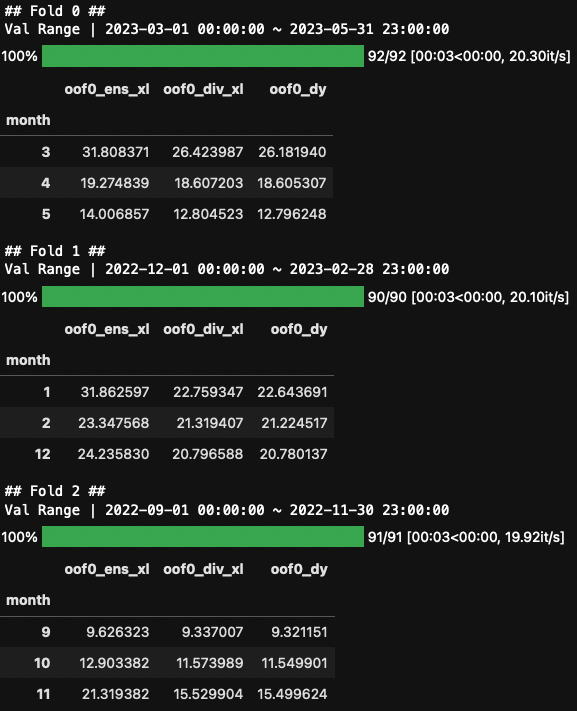

3. 

In [133]:
for fold in range(3):
    y_fold = y[y[f"fold{fold}_eval"] == 1].reset_index(drop=True)
    y_fold_pred = y_fold[["is_business", "seg", "datetime", "target"] + oof_cands]
    
    print(f"## Fold {fold} ##")
    print(f"Val Range | {y_fold['datetime'].min()} ~ {y_fold['datetime'].max()}")
    
    # Perform dynamic model switching
    oof_dy = "oof0_dy"
    y_fold_pred["date"] = y_fold_pred["datetime"].dt.date
    y_fold_pred[oof_dy] = np.zeros((len(y_fold_pred), ))

    for i, (dt, gp) in tqdm(enumerate(y_fold_pred.groupby("date")), total=y_fold_pred["date"].nunique()):
        if i < 2: continue
        # if i < 7: continue

        # Compute segment-wise MAE
        dt_lag2d = dt - timedelta(days=2)
        # dt_lag7d = dt - timedelta(days=7)
        y_fold_pred_long = y_fold_pred[y_fold_pred["date"] <= dt_lag2d]
        # y_fold_pred_long = y_fold_pred[y_fold_pred["date"] == dt_lag7d]
        # y_fold_pred_long = y_fold_pred[y_fold_pred["date"].isin([dt_lag2d, dt_lag7d])]
        
        seg_mae = _get_seg_mae(y_fold_pred_long, oof_cands, mae_cols)

        # Perform dynamic model switching
        dt_mask = (y_fold_pred["date"] == dt)
        # y_fold_pred.loc[dt_mask, oof_dy] = y_fold_pred.loc[dt_mask, base_col]  # Dcap as base for prod
        # y_fold_pred.loc[dt_mask, oof_dy] = y_fold_pred.loc[dt_mask, base_col]  # Ens of dcap & deic as base for cons_c
        y_fold_pred.loc[dt_mask, oof_dy] = y_fold_pred.loc[dt_mask, base_col]  # Ens of raw & diff as base for cons_b
        
        # == Retrieve directly ==
        best_model_types = seg_mae.idxmin(axis=1)
        # seg_mae["mae_oof0_raw"] = seg_mae["mae_oof0_raw"] * 2  # Raw performs the worst, raise its selection condition
        # best_model_types = seg_mae.idxmin(axis=1)
        # seg_mae["mae_oof0_dcap"] = seg_mae["mae_oof0_dcap"] * 1.15
        # best_model_types = seg_mae.idxmin(axis=1)
        
        # Start replacing
        for c in mae_cols:
            # if "dcap" in c: continue
            # if "div" in c: continue
            if c != "oof0_dcap_xl": continue
            slc_seg_list = best_model_types[best_model_types == c].index.tolist()
            mask = y_fold_pred["seg"].isin(slc_seg_list) & dt_mask
            if len(mask) > 0:
                # y_fold_pred.loc[mask, oof_dy] = y_fold_pred.loc[mask, [base_col, c.replace("mae_", "")]].sum(axis=1) / 2
                tmp = y_fold_pred.loc[mask, base_col] * 2
                y_fold_pred.loc[mask, oof_dy] = (tmp + y_fold_pred.loc[mask, c.replace("mae_", "")].sum(axis=1)) / 3

    dt_start = y_fold_pred["date"].min() + timedelta(days=2)
    # dt_start = y_fold_pred["date"].min() + timedelta(days=7)
    y_fold_pred = y_fold_pred[y_fold_pred["date"] >= dt_start].reset_index(drop=True)

    y_fold_pred["month"] = y_fold_pred["datetime"].dt.month
    b = []
    for i, c in enumerate(oof_cands + [oof_dy]):
        # print(f"== {c} ==-")
        # a = y_fold_pred.groupby(["month", "is_business"]).apply(lambda x: mae(x["target"], x[c])).to_frame(name=c)
        a = y_fold_pred.groupby(["month"]).apply(lambda x: mae(x["target"], x[c])).to_frame(name=c)
        b.append(a)
        
    display(pd.concat(b, axis=1))
        # print(f"    >> {c:<16}: {mae(y_fold_pred['target'], y_fold_pred[c]):.4f}")
    # print(f"=> Dynamic OOF: {mae(y_fold_pred['target'], y_fold_pred[oof_dy]):.4f}")  

> Why `dcap` is good at 10 and 11 and how to leverage???

1. Observe one `target` abruptly shirnks, and `dcap` can respond faster than `ens` of `raw` and `diff`.

In [ ]:
for pks, gp in ycb.groupby("seg"):
    gp = gp.sort_values("datetime")
    gp = gp[gp["datetime"] >= datetime(2022, 9, 1, 0)].reset_index(drop=True)
    fig = go.Figure()
    for col in ["target", "oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[col], name=col))
    fig.update_layout(title=f"{pks}")
    fig.show()

In [152]:
ycb.head(1)

In [151]:
with open("./data/processed/feats/v5_cc_dcap.pkl", "rb") as f:
    feats = pickle.load(f)
len(feats)

In [108]:
a = pd.DataFrame([[1, 2], [3, 4], [5, 6]])
a

## Final Feature Selection - Element-Wise Reduction
1. Reduce those with least importances based on **3-fold agreement** strategy
2. Combine with some intuition

In [17]:
with open("./data/processed/feats/v47_study.pkl", "rb") as f:
    feats = pickle.load(f)
feats

In [18]:
with open("./data/processed/feats/v39_study.pkl", "rb") as f:
    feats2 = pickle.load(f)
set(feats2).difference(set(feats))

### *`c_raw`*
For models `c_raw` and `c_diff`.

In [20]:
tid_feats = ['quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear']
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_ratio" in c]
    + [c for c in df.columns if c.endswith("_local_mean") or c.endswith("_global_mean")]
    + [c for c in df.columns if c.endswith(f"_local_mean_hist_lag7d")]
    + ["eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v1_c_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [42]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [f"target_ratio_lag{d}to{d+7}_cons" for d in [2, 3, 4, 7]]
    + [c for c in df.columns if c.endswith("_local_mean") or c.endswith("_global_mean")]
    + ['temperature_local_mean_hist_lag7d',
       'dewpoint_local_mean_hist_lag7d',
       'rain_local_mean_hist_lag7d',
       'snowfall_local_mean_hist_lag7d',
       'surface_pressure_local_mean_hist_lag7d',
       'cloudcover_total_local_mean_hist_lag7d',
       'windspeed_10m_local_mean_hist_lag7d',
       'winddirection_10m_local_mean_hist_lag7d',
       'shortwave_radiation_local_mean_hist_lag7d',
       'direct_solar_radiation_local_mean_hist_lag7d',
       'diffuse_radiation_local_mean_hist_lag7d']
    + ["eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v2_c_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [53]:
fwth_feats = ["temperature", "dewpoint", "cloudcover_low", "cloudcover_total", 
              "direct_solar_radiation", "surface_solar_radiation_downwards", "snowfall", "total_precipitation"]
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [f"target_ratio_lag{d}to{d+7}_cons" for d in [2, 3, 4, 7]]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_global_mean" for c in fwth_feats]
    + ['temperature_local_mean_hist_lag7d',
       'dewpoint_local_mean_hist_lag7d',
       'rain_local_mean_hist_lag7d',
       'snowfall_local_mean_hist_lag7d',
       'surface_pressure_local_mean_hist_lag7d',
       'cloudcover_total_local_mean_hist_lag7d',
       'windspeed_10m_local_mean_hist_lag7d',
       'winddirection_10m_local_mean_hist_lag7d',
       'shortwave_radiation_local_mean_hist_lag7d',
       'direct_solar_radiation_local_mean_hist_lag7d',
       'diffuse_radiation_local_mean_hist_lag7d']
    + ["eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v3_c_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [57]:
fwth_feats = ["temperature", "dewpoint", "cloudcover_low", 
              "direct_solar_radiation", "surface_solar_radiation_downwards", "snowfall", "total_precipitation"]
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [f"target_ratio_lag{d}to{d+7}_cons" for d in [2, 3, 4, 7]]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_global_mean" for c in fwth_feats]
    + ['temperature_local_mean_hist_lag7d',
       'dewpoint_local_mean_hist_lag7d',
       'rain_local_mean_hist_lag7d',
       'surface_pressure_local_mean_hist_lag7d',
       'cloudcover_total_local_mean_hist_lag7d',
       'shortwave_radiation_local_mean_hist_lag7d',
       'direct_solar_radiation_local_mean_hist_lag7d',
       'diffuse_radiation_local_mean_hist_lag7d']
    + ["eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v4_c_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [60]:
fwth_feats = ["temperature", "dewpoint", "cloudcover_low", 
              "direct_solar_radiation", "surface_solar_radiation_downwards", "snowfall", "total_precipitation"]
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [f"target_ratio_lag{d}to{d+7}_cons" for d in [2, 3, 4, 7]]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_global_mean" for c in fwth_feats]
    + ['temperature_local_mean_hist_lag7d',
       'dewpoint_local_mean_hist_lag7d',
       'surface_pressure_local_mean_hist_lag7d',
       'shortwave_radiation_local_mean_hist_lag7d',
       'direct_solar_radiation_local_mean_hist_lag7d',
       'diffuse_radiation_local_mean_hist_lag7d']
    + ["eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v5_c_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [52]:
[c for c in df.columns if ("_local_mean" in c or "_global_mean" in c) and "_hist_" not in c ]

### *p_raw*
For models `p_raw` and `p_diff`.

In [65]:
fwth_feats = ['temperature', 'dewpoint', 'cloudcover_low', 'cloudcover_mid', 
              'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 
              'surface_solar_radiation_downwards', 'total_precipitation']
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_global_mean" for c in fwth_feats]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v1_p_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [67]:
lfwth_feats = ['temperature', 'cloudcover_low', 'cloudcover_mid', 
              'cloudcover_total', '10_metre_u_wind_component', 'direct_solar_radiation', 
              'surface_solar_radiation_downwards', 'total_precipitation']
gfwth_feats = ['temperature', 'dewpoint', 'cloudcover_low', 'cloudcover_mid', 
              'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 
              'surface_solar_radiation_downwards', 'total_precipitation']
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [f"{c}_local_mean" for c in lfwth_feats]
    + [f"{c}_global_mean" for c in gfwth_feats]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v2_p_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [70]:
lfwth_feats = ['temperature', 'cloudcover_low', 'cloudcover_mid', 
              'direct_solar_radiation', 
              'surface_solar_radiation_downwards', 'total_precipitation']
gfwth_feats = ['dewpoint', 'cloudcover_low', 'cloudcover_mid', 
              '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 
              'surface_solar_radiation_downwards', 'total_precipitation']
feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_lag{d}d_cons" for d in range(2, 8)]
    + [f"{c}_local_mean" for c in lfwth_feats]
    + [f"{c}_global_mean" for c in gfwth_feats]
    + ["installed_capacity_lag2d", "eic_count_lag2d"]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v3_p_raw.pkl", "wb") as f:
    pickle.dump(feats, f)

In [ ]:
for c in ['temperature_local_mean_hist_lag7d',
 'dewpoint_local_mean_hist_lag7d',
 'rain_local_mean_hist_lag7d',
 'snowfall_local_mean_hist_lag7d',
 'surface_pressure_local_mean_hist_lag7d',
 'cloudcover_total_local_mean_hist_lag7d',
 'windspeed_10m_local_mean_hist_lag7d',
 'winddirection_10m_local_mean_hist_lag7d',
 'shortwave_radiation_local_mean_hist_lag7d',
 'direct_solar_radiation_local_mean_hist_lag7d',
 'diffuse_radiation_local_mean_hist_lag7d',]:
    a = df.select(pl.col(c) == 0).sum()
    
    
    fig, ax = plt.subplots(figsize=(16, 3))
    sns.histplot(df[c])
    ax.set_title(f"{c} - {a}")
    plt.show()

In [38]:
df.group_by("month").agg(pl.col("snowfall_local_mean_hist_lag7d").mean()).sort("month")

In [64]:
with open("./data/processed/feats/v2_study.pkl", "rb") as f:
    feats = pickle.load(f)
feats

In [18]:
def _plot_feat_imp(feat_imp, name) -> None:
    # Features Importance
    # Feature_Imp = pd.DataFrame(sorted(zip(model.feature_importances_, all_features)), columns=['Value','Feature'])
    feat_imp.columns = ["Feature", "Value"]
    feat_imp['Value'] = 100* (feat_imp['Value'] / feat_imp['Value'].max()) # Normalisation
    feat_imp = feat_imp.sort_values(by='Value', ascending=False).reset_index(drop=True)

    # Features Importance
    if len(feat_imp) > 90 : plt.figure(figsize=(7, 18))
    elif len(feat_imp) > 60 : plt.figure(figsize=(7, 15))
    elif len(feat_imp) > 30 : plt.figure(figsize=(7, 12))
    else :
        plt.figure(figsize=(5, 5))
    sns.barplot(x="Value", y="Feature", data=feat_imp.head(100))
    plt.title(f'Features Importance ({name})')
    plt.show()

In [44]:
feat_imp_p["feature"].unique()

In [71]:
feat_imp_p = pd.read_parquet("./output/0125-20_29_55/feat_imps.parquet")
for name, gp in feat_imp_p.groupby(["fold", "tgt_type"]):
    print(f"=== {name} ===")
    a = gp.sort_values("importance_gain")
    display(a.head(15))
    # display(a.tail(15))

In [69]:
feat_imp = pd.read_parquet("output/0125-20_02_27/feat_imps.parquet")
feat_imp.head()

In [62]:
for name, gp in feat_imp.groupby(["fold", "tgt_type"]):
    print(f"=== {name} ===")
    a = gp.sort_values("importance_gain")
    display(a.head(15))
    # display(a.tail(15))
    
    
    # _plot_feat_imp(gp.iloc[:, :2], name)

### *p_dcap*

In [12]:
with open("./data/processed/feats/v3_dcap.pkl", "rb") as f:
    feats = pickle.load(f)

In [13]:
feats

In [19]:
tid_feats = ['quarter',
 'month',
 'day',
 'weekday',
 'hour',
 'dayofyear']

In [24]:
lfwth_feats = ['dewpoint', 'cloudcover_low', 'cloudcover_mid', 
               'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',]
gfwth_feats = ['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
               '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',]

feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in [2, 3, 5, 6, 7]]
    + [f"{c}_local_mean" for c in lfwth_feats]
    + [f"{c}_global_mean" for c in gfwth_feats]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v1_p_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [27]:
lfwth_feats = ['dewpoint', 'cloudcover_low', 
               'direct_solar_radiation', 'surface_solar_radiation_downwards', 'total_precipitation',]
gfwth_feats = ['temperature', 'dewpoint', 'cloudcover_low', 'cloudcover_mid', 
               '10_metre_u_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation',]

feats = (
    TGT_PK_COLS
    + tid_feats
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in [2, 6, 7]]
    + [f"{c}_local_mean" for c in lfwth_feats]
    + [f"{c}_global_mean" for c in gfwth_feats]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v2_p_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [12]:
p_dcap = _load_oof("0126-19_07_09")
yp_div = _align_oof(y_true_div, [p_dcap], tscv=tscv)
mask = yp_div["is_consumption"] == 0
yp_div = yp_div[mask].reset_index(drop=True)
_show_gp_prf(yp_div, is_cons=0)

In [17]:
_show_gp_prf(y_comb, n_oofs=3, is_cons=0)

In [13]:
yp_div.head(1)

In [14]:
y_comb = y_comb.merge(yp_div[TGT_PK_COLS + ["datetime", "oof0"]], how="left", suffixes=("", "_dcap"))
y_comb = y_comb.rename({"oof0": "oof0_dcap"}, axis=1)
y_comb.head(1)

In [ ]:
for pk, gp in y_comb.groupby(TGT_PK_COLS):
    gp = gp.sort_values("datetime")
    gp = gp[gp["datetime"] >= datetime(2022, 9, 1, 0)].reset_index(drop=True)
    fig = go.Figure()
    for col in ["target", "oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[col], name=col))
    fig.update_layout(title=f"{pk}")
    fig.show()

In [28]:
feat_imp_p = pd.read_parquet("./output/0126-19_54_57/feat_imps.parquet")
for name, gp in feat_imp_p.groupby(["fold", "tgt_type"]):
    print(f"=== {name} ===")
    a = gp.sort_values("importance_gain")
    display(a.head(15))
    # _plot_feat_imp(gp.iloc[:, :2], name)   

### *cc_dcap*

In [57]:
['temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 '10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'direct_solar_radiation',
 'surface_solar_radiation_downwards',
 'snowfall',
 'total_precipitation']

In [ ]:
['temperature', 'dewpoint', 'rain', 'snowfall',
 'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
 'cloudcover_high', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
 'direct_solar_radiation', 'diffuse_radiation']

In [29]:
with open("./data/processed/feats/v5_dcap.pkl", "rb") as f:
    feats = pickle.load(f)
feats

In [62]:
fwth_feats = ['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid',
              'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards',
              'snowfall', 'total_precipitation']
hwth_feats = ['temperature', 'dewpoint', 'snowfall',
              'surface_pressure', 'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
              'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
              'direct_solar_radiation', 'diffuse_radiation']

feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_local_mean_hist_lag7d" for c in hwth_feats]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v1_cc_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [64]:
fwth_feats = ['temperature', 'dewpoint', 'cloudcover_low',
              'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards',
              'snowfall', 'total_precipitation']
hwth_feats = ['temperature', 'dewpoint', 'snowfall',
              'surface_pressure', 'cloudcover_total', 'cloudcover_low',
              'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
              'direct_solar_radiation', 'diffuse_radiation']

feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in [2, 3, 6, 7]]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_local_mean_hist_lag7d" for c in hwth_feats]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v2_cc_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [66]:
fwth_feats = ['temperature', 'dewpoint', 'cloudcover_low',
              'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards',
              'snowfall', 'total_precipitation']
hwth_feats = ['temperature', 'dewpoint', 'snowfall',
              'surface_pressure', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation',
              'direct_solar_radiation', 'diffuse_radiation']

feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in [2, 7]]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_local_mean_hist_lag7d" for c in hwth_feats]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v3_cc_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [68]:
fwth_feats = ['temperature', 'dewpoint', 'cloudcover_low',
              '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards',
              'snowfall', 'total_precipitation']
hwth_feats = ['temperature', 'dewpoint', 'snowfall',
              'surface_pressure', 'windspeed_10m']

feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in [2, 7]]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_local_mean_hist_lag7d" for c in hwth_feats]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v4_cc_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [71]:
fwth_feats = ['temperature', 'dewpoint', 'cloudcover_low', 'direct_solar_radiation', 'surface_solar_radiation_downwards',
              'snowfall']
hwth_feats = ['temperature', 'dewpoint', 'snowfall', 'surface_pressure']

feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in [2, 7]]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [f"{c}_local_mean" for c in fwth_feats]
    + [f"{c}_local_mean_hist_lag7d" for c in hwth_feats]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v5_cc_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [50]:
cc_dcap = _load_oof("0126-20_02_17")
ycc_div = _align_oof(y_true_div, [cc_dcap], tscv=tscv)
mask = (ycc_div["is_consumption"] == 1) & (ycc_div["is_business"] == 0)
ycc_div = ycc_div[mask].reset_index(drop=True)
_show_gp_prf(ycc_div, is_cons=1, is_bus=0)

In [51]:
y_c_comb = y_c_comb[y_c_comb["is_business"] == 0].reset_index(drop=True)
y_c_comb.shape, ycc_div.shape

In [52]:
y_c_comb = y_c_comb.merge(ycc_div[TGT_PK_COLS + ["datetime", "oof0"]], how="left", suffixes=("", "_dcap"))
y_c_comb = y_c_comb.rename({"oof0": "oof0_dcap"}, axis=1)
y_c_comb.head(1)

In [ ]:
for pk, gp in y_c_comb.groupby(TGT_PK_COLS):
    gp = gp.sort_values("datetime")
    gp = gp[gp["datetime"] >= datetime(2022, 9, 1, 0)].reset_index(drop=True)
    fig = go.Figure()
    for col in ["target", "oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[col], name=col))
    fig.update_layout(title=f"{pk}")
    fig.show()

In [55]:
_show_gp_prf(y_c_comb, is_cons=1, is_bus=0)

In [69]:
feat_imp_c = pd.read_parquet("./output/0126-21_08_11/feat_imps.parquet")
for name, gp in feat_imp_c.groupby(["fold", "tgt_type"]):
    print(f"=== {name} ===")
    a = gp.sort_values("importance_gain")
    display(a.head(15))
    # _plot_feat_imp(gp.iloc[:, :2], name)   

### *cb_dcap*

In [25]:
with open("./data/processed/feats/v10_dcap.pkl", "rb") as f:
    feats = pickle.load(f)
feats

In [20]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in [2, 7]]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [c for c in df.columns if c.endswith("_local_mean") or c.endswith("_global_mean")]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v1_cb_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [22]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in [2, 3, 6, 7]]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [c for c in df.columns if c.endswith("_local_mean") or c.endswith("_global_mean")]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v2_cb_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [27]:
feats = (
    TGT_PK_COLS
    + tid_feats
    + ["is_country_holiday"]
    + [f"target_div_cap_lag2d_lag{d}d_prod" for d in range(2, 8)]
    + [f"target_div_cap_lag2d_lag{d}d_cons" for d in range(2, 8)]
    + [c for c in df.columns if "target_div_cap_lag2d_ratio" in c and "prod" not in c]
    + [c for c in df.columns if c.endswith("_local_mean") or c.endswith("_global_mean")]
)
print(f"Feature set (# = {len(feats)}):", feats)

with open("./data/processed/feats/v3_cb_dcap.pkl", "wb") as f:
    pickle.dump(feats, f)

In [28]:
cb_dcap1 = _load_oof("0126-21_19_37")
cb_dcap2 = _load_oof("0126-21_51_22")
ycb_div = _align_oof(y_true_div, [cb_dcap1, cb_dcap2], tscv=tscv)
mask = (ycb_div["is_consumption"] == 1) & (ycb_div["is_business"] == 1)
ycb_div = ycb_div[mask].reset_index(drop=True)
_show_gp_prf(ycb_div, is_cons=1, is_bus=1)

In [13]:
cb_dcap = _load_oof("0126-21_19_37")
ycb_div = _align_oof(y_true_div, [cb_dcap], tscv=tscv)
mask = (ycb_div["is_consumption"] == 1) & (ycb_div["is_business"] == 1)
ycb_div = ycb_div[mask].reset_index(drop=True)
_show_gp_prf(ycb_div, is_cons=1, is_bus=1)

In [14]:
y_c_comb = y_c_comb[y_c_comb["is_business"] == 1].reset_index(drop=True)
y_c_comb = y_c_comb.merge(ycb_div[TGT_PK_COLS + ["datetime", "oof0"]], how="left", suffixes=("", "_dcap"))
y_c_comb = y_c_comb.rename({"oof0": "oof0_dcap"}, axis=1)
y_c_comb.head(1)

In [ ]:
for pk, gp in y_c_comb.groupby(TGT_PK_COLS):
    gp = gp.sort_values("datetime")
    gp = gp[gp["datetime"] >= datetime(2022, 9, 1, 0)].reset_index(drop=True)
    fig = go.Figure()
    for col in ["target", "oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[col], name=col))
    fig.update_layout(title=f"{pk}")
    fig.show()

In [15]:
_show_gp_prf(y_c_comb, is_cons=1, is_bus=1)

In [29]:
feat_imp_c = pd.read_parquet("./output/0126-21_51_22/feat_imps.parquet")
for name, gp in feat_imp_c.groupby(["fold", "tgt_type"]):
    print(f"=== {name} ===")
    a = gp.sort_values("importance_gain")
    display(a.head(15))
    # _plot_feat_imp(gp.iloc[:, :2], name)   

### *cc_deic*

In [46]:
# with open("./data/processed/feats/v1_deic.pkl", "rb") as f:
    # feats = pickle.load(f)
feats

In [52]:
feats2 = ['county', 'is_business', 'product_type',
          'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
          'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag3d_prod', 'target_div_eic_lag2d_lag4d_prod', 'target_div_eic_lag2d_lag5d_prod', 'target_div_eic_lag2d_lag6d_prod', 'target_div_eic_lag2d_lag7d_prod',
          'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
          'target_div_eic_lag2d_ratio_lag2to9_cons', 'target_div_eic_lag2d_ratio_lag3to10_cons', 'target_div_eic_lag2d_ratio_lag4to11_cons', 'target_div_eic_lag2d_ratio_lag7to14_cons',
         'temperature_local_mean',
         'dewpoint_local_mean',
         'cloudcover_low_local_mean',
         'cloudcover_mid_local_mean',
         'cloudcover_total_local_mean',
         '10_metre_u_wind_component_local_mean',
         '10_metre_v_wind_component_local_mean',
         'direct_solar_radiation_local_mean',
         'surface_solar_radiation_downwards_local_mean',
         'snowfall_local_mean',
         'total_precipitation_local_mean',
         'temperature_local_mean_hist_lag7d',
         'dewpoint_local_mean_hist_lag7d',
         'snowfall_local_mean_hist_lag7d',
         'surface_pressure_local_mean_hist_lag7d',
         'cloudcover_total_local_mean_hist_lag7d',
         'cloudcover_low_local_mean_hist_lag7d',
         'cloudcover_high_local_mean_hist_lag7d',
         'windspeed_10m_local_mean_hist_lag7d',
         'winddirection_10m_local_mean_hist_lag7d',
         'shortwave_radiation_local_mean_hist_lag7d',
         'direct_solar_radiation_local_mean_hist_lag7d',
         'diffuse_radiation_local_mean_hist_lag7d']

with open("./data/processed/feats/v1_cc_deic.pkl", "wb") as f:
    pickle.dump(feats2, f)

In [57]:
feats3 = ['county', 'is_business', 'product_type',
          'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
          'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag3d_prod', 'target_div_eic_lag2d_lag6d_prod', 'target_div_eic_lag2d_lag7d_prod',
          'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
          'target_div_eic_lag2d_ratio_lag2to9_cons', 'target_div_eic_lag2d_ratio_lag3to10_cons', 'target_div_eic_lag2d_ratio_lag4to11_cons', 'target_div_eic_lag2d_ratio_lag7to14_cons',
         'temperature_local_mean',
         'dewpoint_local_mean',
         'cloudcover_low_local_mean',
         'cloudcover_mid_local_mean',
         'cloudcover_total_local_mean',
         '10_metre_u_wind_component_local_mean',
         '10_metre_v_wind_component_local_mean',
         'direct_solar_radiation_local_mean',
         'surface_solar_radiation_downwards_local_mean',
         'snowfall_local_mean',
         'total_precipitation_local_mean',
         'temperature_local_mean_hist_lag7d',
         'dewpoint_local_mean_hist_lag7d',
         'snowfall_local_mean_hist_lag7d',
         'surface_pressure_local_mean_hist_lag7d',
         'cloudcover_total_local_mean_hist_lag7d',
         'winddirection_10m_local_mean_hist_lag7d',
         'shortwave_radiation_local_mean_hist_lag7d',
         'direct_solar_radiation_local_mean_hist_lag7d',
         'diffuse_radiation_local_mean_hist_lag7d']
print(len(feats3))

with open("./data/processed/feats/v2_cc_deic.pkl", "wb") as f:
    pickle.dump(feats3, f)

In [58]:
feats3 = ['county', 'is_business', 'product_type',
          'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
          'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag6d_prod', 'target_div_eic_lag2d_lag7d_prod',
          'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
          'target_div_eic_lag2d_ratio_lag2to9_cons', 'target_div_eic_lag2d_ratio_lag3to10_cons', 'target_div_eic_lag2d_ratio_lag4to11_cons', 'target_div_eic_lag2d_ratio_lag7to14_cons',
         'temperature_local_mean',
         'dewpoint_local_mean',
         'cloudcover_low_local_mean',
         '10_metre_u_wind_component_local_mean',
         '10_metre_v_wind_component_local_mean',
         'direct_solar_radiation_local_mean',
         'surface_solar_radiation_downwards_local_mean',
         'snowfall_local_mean',
         'total_precipitation_local_mean',
         'temperature_local_mean_hist_lag7d',
         'dewpoint_local_mean_hist_lag7d',
         'snowfall_local_mean_hist_lag7d',
         'surface_pressure_local_mean_hist_lag7d',
         'winddirection_10m_local_mean_hist_lag7d',
         'shortwave_radiation_local_mean_hist_lag7d',
         'direct_solar_radiation_local_mean_hist_lag7d',
         'diffuse_radiation_local_mean_hist_lag7d']
print(len(feats3))

with open("./data/processed/feats/v3_cc_deic.pkl", "wb") as f:
    pickle.dump(feats3, f)

In [60]:
feats4 = ['county', 'is_business', 'product_type',
          'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
          'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag6d_prod', 'target_div_eic_lag2d_lag7d_prod',
          'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
          'target_div_eic_lag2d_ratio_lag7to14_cons',
         'temperature_local_mean',
         'dewpoint_local_mean',
         'cloudcover_low_local_mean',
         'direct_solar_radiation_local_mean',
         'surface_solar_radiation_downwards_local_mean',
         'snowfall_local_mean',
         'total_precipitation_local_mean',
         'temperature_local_mean_hist_lag7d',
         'dewpoint_local_mean_hist_lag7d',
         'snowfall_local_mean_hist_lag7d',
         'surface_pressure_local_mean_hist_lag7d',
         'winddirection_10m_local_mean_hist_lag7d',
         'shortwave_radiation_local_mean_hist_lag7d',
         'direct_solar_radiation_local_mean_hist_lag7d',
         'diffuse_radiation_local_mean_hist_lag7d']
print(len(feats4))

with open("./data/processed/feats/v4_cc_deic.pkl", "wb") as f:
    pickle.dump(feats4, f)

In [62]:
feats5 = ['county', 'is_business', 'product_type',
          'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
          'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag7d_prod',
          'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
          'target_div_eic_lag2d_ratio_lag7to14_cons',
         'temperature_local_mean',
         'dewpoint_local_mean',
         'cloudcover_low_local_mean',
         'direct_solar_radiation_local_mean',
         'surface_solar_radiation_downwards_local_mean',
         'snowfall_local_mean',
         'total_precipitation_local_mean',
         'temperature_local_mean_hist_lag7d',
         'dewpoint_local_mean_hist_lag7d',
         'surface_pressure_local_mean_hist_lag7d',
         'shortwave_radiation_local_mean_hist_lag7d',
         'direct_solar_radiation_local_mean_hist_lag7d',
         'diffuse_radiation_local_mean_hist_lag7d']
print(len(feats5))

with open("./data/processed/feats/v5_cc_deic.pkl", "wb") as f:
    pickle.dump(feats5, f)

In [66]:
feats6 = ['county', 'is_business', 'product_type',
          'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
          'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
          'target_div_eic_lag2d_ratio_lag7to14_cons',
         'temperature_local_mean',
         'dewpoint_local_mean',
         'cloudcover_low_local_mean',
         'direct_solar_radiation_local_mean',
         'surface_solar_radiation_downwards_local_mean',
         'snowfall_local_mean',
         'temperature_local_mean_hist_lag7d',
         'dewpoint_local_mean_hist_lag7d',
         'shortwave_radiation_local_mean_hist_lag7d',
         'direct_solar_radiation_local_mean_hist_lag7d',
         'diffuse_radiation_local_mean_hist_lag7d']
print(len(feats6))

with open("./data/processed/feats/v6_cc_deic.pkl", "wb") as f:
    pickle.dump(feats6, f)

In [65]:
feat_imp = pd.read_parquet("output/0130-23_36_12/feat_imps.parquet")
for name, gp in feat_imp.groupby(["fold", "tgt_type"]):
    print(f"=== {name} ===")
    a = gp.sort_values("importance_gain")
    display(a.head(15))
    # display(a.tail(15))

### *cb_deic*

In [12]:
with open("./data/processed/feats/v3_deic.pkl", "rb") as f:
    feats = pickle.load(f)
feats

In [13]:
len(feats)

In [ ]:
# feats1 = ['county', 'is_business', 'product_type',
#  'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
#  'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag3d_prod', 'target_div_eic_lag2d_lag4d_prod', 'target_div_eic_lag2d_lag5d_prod', 'target_div_eic_lag2d_lag6d_prod', 'target_div_eic_lag2d_lag7d_prod',
#  'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
#  'target_div_eic_lag2d_ratio_lag2to9_prod',
#  'target_div_eic_lag2d_ratio_lag3to10_prod',
#  'target_div_eic_lag2d_ratio_lag4to11_prod',
#  'target_div_eic_lag2d_ratio_lag7to14_prod',
#  'target_div_eic_lag2d_ratio_lag2to9_cons',
#  'target_div_eic_lag2d_ratio_lag3to10_cons',
#  'target_div_eic_lag2d_ratio_lag4to11_cons',
#  'target_div_eic_lag2d_ratio_lag7to14_cons',
#  'temperature_local_mean',
#  'dewpoint_local_mean',
#  'cloudcover_high_local_mean',
#  'cloudcover_low_local_mean',
#  'cloudcover_mid_local_mean',
#  'cloudcover_total_local_mean',
#  '10_metre_u_wind_component_local_mean',
#  '10_metre_v_wind_component_local_mean',
#  'direct_solar_radiation_local_mean',
#  'surface_solar_radiation_downwards_local_mean',
#  'snowfall_local_mean',
#  'total_precipitation_local_mean',
#  'temperature_global_mean',
#  'dewpoint_global_mean',
#  'cloudcover_high_global_mean',
#  'cloudcover_low_global_mean',
#  'cloudcover_mid_global_mean',
#  'cloudcover_total_global_mean',
#  '10_metre_u_wind_component_global_mean',
#  '10_metre_v_wind_component_global_mean',
#  'direct_solar_radiation_global_mean',
#  'surface_solar_radiation_downwards_global_mean',
#  'snowfall_global_mean',
#  'total_precipitation_global_mean']
# print(len(feats1))

# with open("./data/processed/feats/v1_cb_deic.pkl", "wb") as f:
#     pickle.dump(feats1, f)

In [147]:
feats1 = ['county', 'is_business', 'product_type',
 'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
 'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag3d_prod', 'target_div_eic_lag2d_lag4d_prod', 'target_div_eic_lag2d_lag5d_prod', 'target_div_eic_lag2d_lag6d_prod', 'target_div_eic_lag2d_lag7d_prod',
 'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
 'target_div_eic_lag2d_ratio_lag2to9_prod',
 'target_div_eic_lag2d_ratio_lag7to14_prod',
 'target_div_eic_lag2d_ratio_lag2to9_cons',
 'target_div_eic_lag2d_ratio_lag3to10_cons',
 'target_div_eic_lag2d_ratio_lag4to11_cons',
 'target_div_eic_lag2d_ratio_lag7to14_cons',
 'temperature_local_mean',
 'dewpoint_local_mean',
 'cloudcover_low_local_mean',
 'cloudcover_mid_local_mean',
 'cloudcover_total_local_mean',
 '10_metre_u_wind_component_local_mean',
 '10_metre_v_wind_component_local_mean',
 'direct_solar_radiation_local_mean',
 'surface_solar_radiation_downwards_local_mean',
 'snowfall_local_mean',
 'total_precipitation_local_mean',
 'temperature_global_mean',
 'dewpoint_global_mean',
 'cloudcover_low_global_mean',
 'cloudcover_total_global_mean',
 '10_metre_u_wind_component_global_mean',
 '10_metre_v_wind_component_global_mean',
 'direct_solar_radiation_global_mean',
 'surface_solar_radiation_downwards_global_mean',
 'total_precipitation_global_mean']
print(len(feats1))

with open("./data/processed/feats/v1_cb_deic.pkl", "wb") as f:
    pickle.dump(feats1, f)

In [148]:
feats2 =['county', 'is_business', 'product_type',
 'quarter', 'month', 'day', 'weekday', 'hour', 'dayofyear', 'is_country_holiday',
 'target_div_eic_lag2d_lag2d_prod', 'target_div_eic_lag2d_lag3d_prod', 'target_div_eic_lag2d_lag4d_prod', 'target_div_eic_lag2d_lag5d_prod', 'target_div_eic_lag2d_lag6d_prod', 'target_div_eic_lag2d_lag7d_prod',
 'target_div_eic_lag2d_lag2d_cons', 'target_div_eic_lag2d_lag3d_cons', 'target_div_eic_lag2d_lag4d_cons', 'target_div_eic_lag2d_lag5d_cons', 'target_div_eic_lag2d_lag6d_cons', 'target_div_eic_lag2d_lag7d_cons',
 'target_div_eic_lag2d_ratio_lag2to9_prod',
 'target_div_eic_lag2d_ratio_lag7to14_prod',
 'target_div_eic_lag2d_ratio_lag2to9_cons',
 'target_div_eic_lag2d_ratio_lag3to10_cons',
 'target_div_eic_lag2d_ratio_lag4to11_cons',
 'target_div_eic_lag2d_ratio_lag7to14_cons',
 'temperature_local_mean',
 'dewpoint_local_mean',
 'cloudcover_high_local_mean',
 'cloudcover_low_local_mean',
 'cloudcover_mid_local_mean',
 'cloudcover_total_local_mean',
 '10_metre_u_wind_component_local_mean',
 '10_metre_v_wind_component_local_mean',
 'direct_solar_radiation_local_mean',
 'surface_solar_radiation_downwards_local_mean',
 'snowfall_local_mean',
 'total_precipitation_local_mean',
 'temperature_global_mean',
 'dewpoint_global_mean',
 'cloudcover_high_global_mean',
 'cloudcover_low_global_mean',
 'cloudcover_mid_global_mean',
 'cloudcover_total_global_mean',
 '10_metre_u_wind_component_global_mean',
 '10_metre_v_wind_component_global_mean',
 'direct_solar_radiation_global_mean',
 'surface_solar_radiation_downwards_global_mean',
 'snowfall_global_mean',
 'total_precipitation_global_mean']
print(len(feats2))

with open("./data/processed/feats/v2_cb_deic.pkl", "wb") as f:
    pickle.dump(feats2, f)

In [136]:
o1 = _load_oof("0131-05_10_20")
y1 = _align_oof(y_true_div, [o1], tscv)
_ = _show_gp_prf(y1, is_cons=1, is_bus=1)

In [140]:
o1 = _load_oof("0131-05_23_19")
y1 = _align_oof(y_true_div, [o1], tscv)
_ = _show_gp_prf(y1, is_cons=1, is_bus=1) 

In [11]:
o1 = _load_oof("0131-05_34_41")
y1 = _align_oof(y_true_div, [o1], tscv)
_ = _show_gp_prf(y1, is_cons=1, is_bus=1) 

In [137]:
feat_imp = pd.read_parquet("output/0131-05_10_20/feat_imps.parquet")
for name, gp in feat_imp.groupby(["fold", "tgt_type"]):
    print(f"=== {name} ===")
    a = gp.sort_values("importance_gain")
    display(a.head(15))
    # display(a.tail(15))

## Run Unseen Meter Test

Design a strategy for handling unseen meters.

Which one can handle unseen well, raw, diff, ens or dcap??? Then, for unseen, directly select that type for submission???
> Maybe diff also performs worse on unseen, let's test it !!

In [85]:
df = df.with_columns(
            pl.concat_str(*(TGT_PK_COLS+["is_consumption"]), separator="_").alias("seg")
        )

In [91]:
sorted(df.filter(pl.col("is_consumption") == 0).select("seg").unique()["seg"].to_list())

In [27]:
uniq_units = df.select(TGT_PK_COLS).unique().sort(TGT_PK_COLS)
holdout_units = []
for county, gp in uniq_units.group_by("county"):
    if county in [6, 12]: 
        assert len(gp) == 1
        print("Only one unit in county, skip...")
        continue
        
    holdout_idx = random.randint(0, len(gp)-1)
    holdout_unit = gp.row(holdout_idx)
    county, is_business, product_type = holdout_unit
    holdout_units.append(f"{county}_{is_business}_{product_type}")
    print(f"Holdout unit in county {county} (out of {len(gp)} units): county {county}, is_bus {is_business}, product_type {product_type}")

In [28]:
holdout_units

In [29]:
tmp = uniq_units.to_pandas()
tmp.head()

In [30]:
tmp2 = tmp.iloc[[0, 1, 3, 5, 7, 8 ,9]]
tmp2

In [41]:
tscv = TSCV(3, 3, 0)

In [42]:
p_raw = _load_oof("0127-04_09_27")
p_diff = _load_oof("0127-04_17_21")
p_dcap = _load_oof("0127-04_24_36")
yp_raw = _align_oof(y_true_raw, [p_raw], tscv=tscv)
yp_diff = _align_oof(y_true_diff, [p_diff], tscv=tscv)
yp_dcap = _align_oof(y_true_div, [p_dcap], tscv=tscv)
yp_raw.shape, yp_diff.shape, yp_dcap.shape

In [43]:
yp_raw = yp_raw[yp_raw["is_consumption"] == 0].reset_index(drop=True)
yp_diff = yp_diff[yp_diff["is_consumption"] == 0].reset_index(drop=True)
yp_dcap = yp_dcap[yp_dcap["is_consumption"] == 0].reset_index(drop=True)
yp = (
    yp_diff
    .merge(yp_dcap[TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_diff", "_dcap"))
    .merge(yp_raw[TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left")
)
yp = yp.rename({"oof0": "oof0_raw"}, axis=1)
yp["oof0_ens"] = (yp["oof0_raw"] + yp["oof0_diff"]) / 2
yp["seg"] = yp["county"].astype(str).str.cat(yp["is_business"].astype(str),  sep="_").str.cat(yp["product_type"].astype(str),  sep="_")
yp.head()

In [47]:
yp_unseen = yp[yp["seg"].isin(holdout_units)].reset_index(drop=True)
for pks, gp in yp_unseen.groupby("seg"):
    gp = gp.sort_values("datetime")
    gp = gp[gp["datetime"] >= datetime(2022, 9, 1, 0)].reset_index(drop=True)
    fig = go.Figure()
    for col in ["target", "oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[col], name=col))
    fig.update_layout(title=f"{pks}")
    fig.show()

`dcap` still the best for unseen in prod.

In [49]:
_show_gp_prf(yp_unseen, is_cons=0)

In [56]:
cc_raw = _load_oof("0127-04_12_14")
cc_diff = _load_oof("0127-04_19_51")
cc_dcap = _load_oof("0127-04_27_30")
ycc_raw = _align_oof(y_true_raw, [cc_raw], tscv=tscv)
ycc_diff = _align_oof(y_true_diff, [cc_diff], tscv=tscv)
ycc_dcap = _align_oof(y_true_div, [cc_dcap], tscv=tscv)
ycc_raw.shape, ycc_diff.shape, ycc_dcap.shape

In [57]:
ycc_raw = ycc_raw[(ycc_raw["is_consumption"] == 1) & (ycc_raw["is_business"] == 0)].reset_index(drop=True)
ycc_diff = ycc_diff[(ycc_diff["is_consumption"] ==1) & (ycc_diff["is_business"] == 0)].reset_index(drop=True)
ycc_dcap = ycc_dcap[(ycc_dcap["is_consumption"] ==1) & (ycc_dcap["is_business"] == 0)].reset_index(drop=True)
ycc = (
    ycc_diff
    .merge(ycc_dcap[TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_diff", "_dcap"))
    .merge(ycc_raw[TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left")
)
ycc = ycc.rename({"oof0": "oof0_raw"}, axis=1)
ycc["oof0_ens"] = (ycc["oof0_raw"] + ycc["oof0_diff"]) / 2
ycc["seg"] = ycc["county"].astype(str).str.cat(ycc["is_business"].astype(str),  sep="_").str.cat(ycc["product_type"].astype(str),  sep="_")
ycc.head()

In [58]:
ycc_unseen = ycc[ycc["seg"].isin(holdout_units)].reset_index(drop=True)
for pks, gp in ycc_unseen.groupby("seg"):
    gp = gp.sort_values("datetime")
    gp = gp[gp["datetime"] >= datetime(2022, 9, 1, 0)].reset_index(drop=True)
    fig = go.Figure()
    for col in ["target", "oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[col], name=col))
    fig.update_layout(title=f"{pks}")
    fig.show()

Ensemble of `raw` and `diff` performs the best for unseen in cons_c. `dcap` is the best in fold0 but just sligtly better than ens.

In [60]:
_show_gp_prf(ycc_unseen, is_cons=1, is_bus=0)

In [64]:
cb_raw = _load_oof("0127-04_12_14")
cb_diff = _load_oof("0127-04_19_51")
cb_dcap = _load_oof("0127-04_30_57")
ycb_raw = _align_oof(y_true_raw, [cb_raw], tscv=tscv)
ycb_diff = _align_oof(y_true_diff, [cb_diff], tscv=tscv)
ycb_dcap = _align_oof(y_true_div, [cb_dcap], tscv=tscv)
ycb_raw.shape, ycb_diff.shape, ycb_dcap.shape

In [65]:
ycb_raw = ycb_raw[(ycb_raw["is_consumption"] == 1) & (ycb_raw["is_business"] == 1)].reset_index(drop=True)
ycb_diff = ycb_diff[(ycb_diff["is_consumption"] ==1) & (ycb_diff["is_business"] == 1)].reset_index(drop=True)
ycb_dcap = ycb_dcap[(ycb_dcap["is_consumption"] ==1) & (ycb_dcap["is_business"] == 1)].reset_index(drop=True)
ycb = (
    ycb_diff
    .merge(ycb_dcap[TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left", suffixes=("_diff", "_dcap"))
    .merge(ycb_raw[TGT_PK_COLS+["datetime", "oof0"]], on=TGT_PK_COLS+["datetime"], how="left")
)
ycb = ycb.rename({"oof0": "oof0_raw"}, axis=1)
ycb["oof0_ens"] = (ycb["oof0_raw"] + ycb["oof0_diff"]) / 2
ycb["seg"] = ycb["county"].astype(str).str.cat(ycb["is_business"].astype(str),  sep="_").str.cat(ycb["product_type"].astype(str),  sep="_")
ycb.head()

In [66]:
ycb_unseen = ycb[ycb["seg"].isin(holdout_units)].reset_index(drop=True)
for pks, gp in ycb_unseen.groupby("seg"):
    gp = gp.sort_values("datetime")
    gp = gp[gp["datetime"] >= datetime(2022, 9, 1, 0)].reset_index(drop=True)
    fig = go.Figure()
    for col in ["target", "oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[col], name=col))
    fig.update_layout(title=f"{pks}")
    fig.show()

`dcap` is always the best for unseen in cons_b.

**But, note that `cons_b` is still the most tricky part.**

In [68]:
_show_gp_prf(ycb_unseen, is_cons=1, is_bus=1)

In [69]:
cc_segs = (
    df
    .filter((pl.col("is_business") == 0) & (pl.col("is_consumption") == 1))
    .select(TGT_PK_COLS+["is_consumption"]).unique().sort(TGT_PK_COLS)
)

In [71]:
cc_segs = cc_segs.with_columns(
    pl.concat_str(*(TGT_PK_COLS+["is_consumption"]), separator="_").alias("seg")
)
cc_segs.head()

In [72]:
cc_segs["seg"].to_list()

### *Prod*

#### **Observation**
1. Raw target model performs the best on fold1, which has the lowest value scale.
2. Div target model performs significantly better than raw target model on fold 0 and 2.
3. Div target model trained on either **raw** or **div** features is good at different periods. That is, sometimes raw features perform better, but div for another period.

Hence, **dynamically adjusting model types** is worth trying. 

<div class="alert alert-block alert-warning">
    But, how to determine <strong>which to use</strong> and <strong>when to switch</strong>?
</div>

In [ ]:
# Check only prod part, cons oof is not filled
oof_raw = np.load("./output/0115-20_10_29/preds/oof.npy")  # Train prod on raw
oof_div1 = np.load("./output/0116-01_11_11/preds/oof.npy")  # Train prod on div with raw feats
oof_div2 = np.load("./output/0116-06_38_33/preds/oof.npy")  # Train prod on div with div feats

In [ ]:
y_raw = _align_oof(y_true_raw, [oof_raw])
y_div = _align_oof(y_true_div, [oof_div1, oof_div2])
y_raw.shape, y_div.shape

In [ ]:
_show_gp_prf(y_raw, is_cons=0)
print("-"*50)
_show_gp_prf(y_div, n_oofs=2, is_cons=0)

In [ ]:
line_styles = ["r-", "g-"]

def _plot_pred(y: pd.DataFrame, pks: Tuple[int, ...], fold: int = 0) -> None:
    county, is_bus, pt = pks
    mask = (y.county == county) & (y.is_business == is_bus) & (y.product_type == pt)
    y_tmp = y[mask]
    oof_cols = [c for c in y.columns if f"fold{fold}" in c and "oof" in c]
    
    fig, ax = plt.subplots(figsize=(20, 3))
    ax2 = ax.twinx()
    ax.plot(y_tmp["datetime"], y_tmp["target"], "b-", label="gt")
    ax2.axhline(y=y_tmp[y_tmp["target"] != 0]["target"].quantile(0.9), color="blue", linestyle="--")
    # ax2.axhline(y=y_tmp[y_tmp["target"] > 1e-3]["target"].quantile(0.5), color="blue", linestyle="--")
    for i, c in enumerate(oof_cols):
        ax.plot(y_tmp["datetime"], y_tmp[c], line_styles[i], label=c)
        ax2.axhline(y=y_tmp[y_tmp[c] != 0][c].quantile(0.9), color=line_styles[i][0], linestyle="--")
        # ax2.axhline(y=y_tmp[y_tmp[c] > 1e-3][c].quantile(0.5), color=line_styles[i][0], linestyle="--")
    ax.set_title(pks)
    ax.legend()
    plt.show()

1. 近夏的prod數值上升，且 quasi-zero 範圍受到壓縮 (*i.e.,* hour plot 兩側近0數值區域變窄)
    * 日照時間增加
    * 日照強度增強
2. 

In [ ]:
y_raw_pfold0 = y_raw.query("is_consumption == 0 and fold0_eval == 1").reset_index(drop=True)
y_div_pfold0 = y_div.query("is_consumption == 0 and fold0_eval == 1").reset_index(drop=True)

In [ ]:
y_raw_pfold0["hour"] = y_raw_pfold0["datetime"].dt.hour
tgt_mean_by_hour = y_raw_pfold0.groupby("hour").agg({"target": ["mean"]})
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(tgt_mean_by_hour.values)
plt.show()

In [ ]:
y_raw_pfold0["fold0_mae"] = (y_raw_pfold0["target"] - y_raw_pfold0["oof0_fold0"]).abs()
mae_by_hour = y_raw_pfold0.groupby("hour").agg({"fold0_mae": ["mean"]})
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(mae_by_hour.values)
plt.show()

In [ ]:
uniq_pks = y_raw_pfold0[TGT_PK_COLS].drop_duplicates().values
for pks in uniq_pks:
    _plot_pred(y_raw_pfold0, tuple(pks), 0)
    _plot_pred(y_div_pfold0, tuple(pks), 0)

In [ ]:
y_raw_pfold1 = y_raw.query("is_consumption == 0 and fold1_eval == 1").reset_index(drop=True)
y_div_pfold1 = y_div.query("is_consumption == 0 and fold1_eval == 1").reset_index(drop=True)

In [ ]:
y_raw_pfold1["hour"] = y_raw_pfold1["datetime"].dt.hour
tgt_mean_by_hour = y_raw_pfold1.groupby("hour").agg({"target": ["mean"]})
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(tgt_mean_by_hour.values)
plt.show()

In [ ]:
y_raw_pfold1["fold1_mae"] = (y_raw_pfold1["target"] - y_raw_pfold1["oof0_fold1"]).abs()
mae_by_hour = y_raw_pfold1.groupby("hour").agg({"fold1_mae": ["mean"]})
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(mae_by_hour.values)
plt.show()

In [ ]:
mask = (y_raw_pfold1.county == 0) & (y_raw_pfold1.is_business == 0) & (y_raw_pfold1.product_type == 1)
y_tmp = y_raw_pfold1[mask]

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_tmp["datetime"], y=y_tmp["target"], name="target"))
fig.show()

In [ ]:
uniq_pks = y_raw_pfold1[TGT_PK_COLS].drop_duplicates().values
for pks in uniq_pks:
    _plot_pred(y_raw_pfold1, tuple(pks), 1)
    _plot_pred(y_div_pfold1, tuple(pks), 1)

### *Cons*

#### **Observation**
1. `cons_c` performs better with div target models sep-trained on `cons_c` only.
    * `cons_b` data is a drag on it.
2. `cons_b` performs unstable on CV/LB (with no luck on sync).
    * Div target models improve a lot on CV, but drop even larger on LB.
    * Sep-training `cons_b` on raw target crashes on fold0, but work find for both fold1 & 2.
        > Still have no idea here...
3. `cons_c` can be trained without `fwth_g_mean` features. As for `cons_b`, including them performs better.
4. `cons_b` can be trained without `hwth_l_mean_lag7d` features.

In short, I now sep-train `cons_c` on div w/o `fwth_g_mean` and co-train `cons` for `cons_b` on raw w/ `fwth_g_mean`.

<div class="alert alert-block alert-warning">
    Sep-training <code>cons_b</code> doesn't work on fold0.
</div>

In [ ]:
# Check only cons part, prod oof is not filled
oof_raw = np.load("./output/0115-23_33_05/preds/oof.npy")  # Co-train cons_c & cons_b on raw
oof_div1 = np.load("./output/0116-01_22_38/preds/oof.npy")  # Sep-train cons_c on div with raw feats
oof_div2 = np.load("./output/0116-06_48_22/preds/oof.npy")  # Sep-train cons_c on div with div feats

In [ ]:
y_raw = _align_oof(y_true_raw, [oof_raw])
y_div = _align_oof(y_true_div, [oof_div1, oof_div2])
y_raw.shape, y_div.shape

In [ ]:
y_comb = y_div.copy()
y_comb = y_comb.merge(y_raw, on=TGT_PK_COLS+["is_consumption", "datetime"], how="left", suffixes=("", "_raw"))
mask = (y_comb["is_consumption"] == 1) & (y_comb["is_business"] == 1)
for fold in range(3):
    y_comb.loc[mask, f"oof1_fold{fold}"] = y_comb.loc[mask, f"oof0_fold{fold}_raw"]

In [ ]:
prfs = []
y_comb_c = y_comb[y_comb["is_consumption"] == 1].reset_index(drop=True)
for fold in range(3):
    y_tmp = y_comb_c[y_comb_c[f"fold{fold}_eval"] == 1]
    prfs.append(mae(y_tmp["target"], y_tmp[f"oof1_fold{fold}"]))
prfs

In [ ]:
np.mean(prfs)

In [ ]:
_show_gp_prf(y_raw, is_cons=1)

In [ ]:
_show_gp_prf(y_div, "target", 2, is_cons=1)

#### **Compare `cons_c` on DCap and DEic Targets**
Though `cons_c` targets show higher corr with `eic`, the performance doesn't improve.

In [ ]:
oof_div1 = np.load("./output/0117-22_24_39/preds/oof.npy")  # Sep-train cons_c on dcap with div feats
oof_div2 = np.load("./output/0118-21_23_21/preds/oof.npy")  # Sep-train cons_c on deic with div feats
y_div = _align_oof(y_true_div, [oof_div1, oof_div2])
_show_gp_prf(y_div, "target", 2, is_cons=1, is_bus=0)

#### **Check if `cons_b` Can Use Div Target Models**

In this experiment, training cons_b with div_cap yields better performance on all folds (specially on fold 2). Also, co-training shows a little bit better but not that much.

<div class="alert alert-danger alert-block">
    It's worth trying div_cap models again for cons_b. But, <strong>fail again</strong>.
</div>

In [ ]:
# Check only cons_b part to verify cons_b prf using div again
oof_raw = np.load("./output/0115-23_33_05/preds/oof.npy")  # Co-train cons_c & cons_b on raw
oof_div1 = np.load("./output/0116-23_43_51/preds/oof.npy")  # Co-train cons_c & cons_b on dcap
oof_div2 = np.load("./output/0118-21_33_07/preds/oof.npy")  # Co-train cons_c & cons_b on deic
# oof_div2 = np.load("./output/0116-23_36_16/preds/oof.npy")  # Sep-train cons_b on div

In [ ]:
y_raw = _align_oof(y_true_raw, [oof_raw])
y_div = _align_oof(y_true_div, [oof_div1, oof_div2])
y_raw.shape, y_div.shape

In [ ]:
y_comb = y_div.copy()
y_comb = y_comb.merge(y_raw, on=TGT_PK_COLS+["is_consumption", "datetime"], how="left", suffixes=("", "_raw"))
mask = (y_comb["is_consumption"] == 1) & (y_comb["is_business"] == 1)
for fold in range(3):
    y_comb.loc[mask, f"oof0_fold{fold}"] = y_comb.loc[mask, f"oof0_fold{fold}_raw"]

prfs = []
y_comb_c = y_comb[y_comb["is_consumption"] == 1].reset_index(drop=True)
for fold in range(3):
    y_tmp = y_comb_c[y_comb_c[f"fold{fold}_eval"] == 1]
    prfs.append(mae(y_tmp["target"], y_tmp[f"oof0_fold{fold}"]))
prfs

In [ ]:
_show_gp_prf(y_raw, is_cons=1)

In [ ]:
_show_gp_prf(y_div, n_oofs=2, is_cons=1)

Let's see which units perform worse in `cons_b`.

In [ ]:
y_raw_cb = y_raw.query("is_business == 1 and is_consumption == 1").reset_index(drop=True)
y_div_cb = y_div.query("is_business == 1 and is_consumption == 1").reset_index(drop=True)
y_raw_cb.shape, y_div_cb.shape

In [ ]:
y_cb = y_raw_cb.merge(y_div_cb.drop("is_consumption", axis=1), on=TGT_PK_COLS+["datetime"], how="left", suffixes=("", "_div"))
y_cb = y_cb.dropna().reset_index(drop=True)

In [ ]:
y_cb.head()

In [ ]:
n_supports_cb = y_cb.groupby(TGT_PK_COLS)["datetime"].count().to_frame("n_supports").reset_index()

In [ ]:
y_cb_prf_report = None
for fold in range(3):
    print(f"## Fold {fold} ##")
    y_cb_fold = y_cb[y_cb[f"fold{fold}_eval"] == 1].reset_index(drop=True)
    prf_raw = y_cb_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_fold{fold}"]))
    prf_dcap  = y_cb_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_fold{fold}_div"]))
    prf_deic  = y_cb_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof1_fold{fold}"]))
    
    prf_raw = prf_raw.to_frame(name=f"mae_raw_fold{fold}").reset_index()
    prf_dcap = prf_dcap.to_frame(name=f"mae_dcap_fold{fold}").reset_index()
    prf_deic = prf_deic.to_frame(name=f"mae_deic_fold{fold}").reset_index()
    
    prf_fold = prf_raw.merge(prf_dcap, on=TGT_PK_COLS, how="left").merge(prf_deic, on=TGT_PK_COLS, how="left")
    if y_cb_prf_report is None:
        y_cb_prf_report = prf_fold
    else:
        y_cb_prf_report = y_cb_prf_report.merge(prf_fold, on=TGT_PK_COLS, how="left")
y_cb_prf_report.head(1)

In [ ]:
y_cb_prf_report = y_cb_prf_report.merge(n_supports_cb, on=TGT_PK_COLS, how="left")

`n_supports` **for each val fold** will affect a unit's contribution to val score. And, this **weight** won't be the same in the test set.

In [ ]:
# Not so accurate approximation of improvement for row 0...
# Suppose each val fold has complete 3-month period
# Then in average, CV improves 17.5 per fold (per 3 months)
# And, consumption of one unit contributes 1 / 2 (is_cons) / 69 (#units) score to total (if all units are equally-weighted)
((33.6 + 18.9) / 3) / 2 / 69

In [ ]:
for fold in range(3):
    y_cb_prf_report[f"mae_improve_dcap_fold{fold}"] = y_cb_prf_report[f"mae_raw_fold{fold}"] - y_cb_prf_report[f"mae_dcap_fold{fold}"]
    y_cb_prf_report[f"mae_improve_deic_fold{fold}"] = y_cb_prf_report[f"mae_raw_fold{fold}"] - y_cb_prf_report[f"mae_deic_fold{fold}"]
    
y_cb_prf_report["cv_improve_dcap"] = (y_cb_prf_report[[f"mae_improve_dcap_fold{fold}" for fold in range(3)]] > 0).all(axis=1).values
y_cb_prf_report["cv_improve_deic"] = (y_cb_prf_report[[f"mae_improve_deic_fold{fold}" for fold in range(3)]] > 0).all(axis=1).values

ycb_prf_report = y_cb_prf_report[["n_supports"] + [c for c in y_cb_prf_report.columns if "improve" in c]]
ycb_prf_report

In [ ]:
selected_dcap = ycb_prf_report[(ycb_prf_report["cv_improve_dcap"])].index# | (ycb_prf_report["cv_improve_deic"])]
y_cb_prf_report.iloc[selected_dcap]

In [ ]:
l = []
for i, r in y_cb_prf_report.iloc[selected_dcap][TGT_PK_COLS].iterrows():
    l.append(f"{r['county']}_1_{r['product_type']}_1")

Still fail to improve on these 8 selected segments using dcap models...

In [ ]:
l

In [ ]:
0.2 / 69

From the perspective of **average MAE among all units with `is_business == 1` (total 38 units)**, we will mis-interpret the performance improvement. Following fine-grained analysis shows that the improvement happens only on a small subset of units.

In [ ]:
y_cb_prf_report[[f"mae_improve_dcap_fold{fold}" for fold in range(3)]].sum() / len(y_cb_prf_report)

In [ ]:
y_cb_prf_report[[f"mae_improve_deic_fold{fold}" for fold in range(3)]].sum() / len(y_cb_prf_report)

In [ ]:
y_cb_prf_report[TGT_PK_COLS + [c for c in y_cb_prf_report.columns if "eic" in c and "improve" in c]]

In [ ]:
y_cb_prf_report[y_cb_prf_report["cv_improve"]]

In [ ]:
y_cb_prf_report[~y_cb_prf_report["cv_improve"]].sort_values("corr_cap")

In [ ]:
y_cb_prf_report.sort_values("corr_cap")

In [ ]:
y_cb_prf_report = y_cb_prf_report.merge(df_corr[df_corr["is_consumption"] == 1], on=TGT_PK_COLS, how="left")
y_cb_prf_report.head()

In [ ]:
df_demo = df.filter((pl.col("county") == 0) & (pl.col("is_business") == 1) & (pl.col("product_type") == 0))
df_demo_p, df_demo_c = df_demo.filter(pl.col("is_consumption") == 0), df_demo.filter(pl.col("is_consumption") == 1)
fig, ax = plt.subplots(figsize=(24, 3))
ax2 = ax.twinx()
ax.plot(df_demo_c["datetime"], df_demo_c["target"])
ax2.plot(df_demo_c["datetime"], df_demo_c["installed_capacity_lag2d"])
plt.show()

In [ ]:
df_bus = df.filter(pl.col("is_business") == 1).select(TGT_PK_COLS + ["is_consumption", "datetime", "target", "installed_capacity_lag2d"])
df_bus.head()

In [ ]:
df.group_by(TGT_PK_COLS).agg(pl.col("target").count().alias("count"))["count"].max()

In [ ]:
N_SAMPS_TOT = 30624
N_UNIQ_DTS = N_SAMPS_TOT // 2  # 15312 == df["datetime"].n_unique()

for pks, gp in df_bus.group_by(TGT_PK_COLS):
    gp = gp.sort("datetime")
    seg = f"county{pks[0]}-is_business{pks[1]}-product_type{pks[2]}"
    missing_ratio = (1 - (len(gp) / 2 / N_UNIQ_DTS)) * 100
    cv_improve = y_cb_prf_report[(y_cb_prf_report["county"] == pks[0]) 
                                 & (y_cb_prf_report["is_business"] == pks[1]) 
                                 & (y_cb_prf_report["product_type"] == pks[2])]["cv_improve"]
    
    fig = px.line(gp, x="datetime", y="target", color="is_consumption")
    fig.update_layout(title=f"Seg {seg} with Missing Ratio {missing_ratio}, CV Improve {cv_improve}")
    fig.show()

In [ ]:
for pks, gp in df_bus.group_by(TGT_PK_COLS):
    print(pks, gp.select(["target", "installed_capacity_lag2d"]).filter(pl.col("installed_capacity_lag2d").is_not_null() & pl.col("target").is_not_null()).corr())

In [ ]:
def _get_corr(gp):
    gp = gp.dropna()
    corr = gp.corr().values[0][1]
    
    return corr
    
df_tmp = df.select(TGT_PK_COLS + ["is_consumption", "datetime", "target"] + ["installed_capacity_lag2d", "eic_count_lag2d"]).to_pandas()
df_corr_cap = df_tmp.groupby(TGT_PK_COLS+["is_consumption"]).apply(lambda gp: _get_corr(gp[["target", "installed_capacity_lag2d"]])).to_frame(name="corr_cap")
df_corr_eic = df_tmp.groupby(TGT_PK_COLS+["is_consumption"]).apply(lambda gp: _get_corr(gp[["target", "eic_count_lag2d"]])).to_frame(name="corr_eic")
df_corr = df_corr_cap.merge(df_corr_eic, on=TGT_PK_COLS+["is_consumption"], how="left").reset_index()

In [ ]:
df_corr.head()

In [ ]:
df_corr.groupby(["is_consumption", "is_business", "product_type"]).agg({"corr_cap": ["mean"], "corr_eic": ["mean"]})

In [ ]:
oof_raw = np.load("./output/0115-23_33_05/preds/oof.npy")
oof_dcap = np.load("./output/0117-22_24_39/preds/oof.npy")


#### **Compare Co-Train `cons` for `cons_b` on Raw Target w&w/o FWTH Global Mean**
It's safe and better to remove `fwth_g_mean` features for training `cons_c` models (the same observation also holds for exp `0117-22_24_39` (sep-train `cons_c` div target model)). As for `cons_b`,

In [ ]:
oof_raw1 = np.load("./output/0115-23_33_05/preds/oof.npy")  # Co-train cons_c & cons_b on raw (w/ fwth_g_mean)
oof_raw2 = np.load("./output/0117-22_11_28/preds/oof.npy")  # Co-train cons_c & cons_b on raw (w/o fwth_g_mean)

In [ ]:
y_raw = _align_oof(y_true_raw, [oof_raw1, oof_raw2])

In [ ]:
_show_gp_prf(y_raw, n_oofs=2, is_cons=1)

#### **Re-Study Feature Selection for `cons_b` on Raw**
Restudying lets me decide to remove `hwth_l_mean_lag7d`.

In [ ]:
with open("./data/processed/feats/v39_study.pkl", "rb") as f:
    feats1 = pickle.load(f)
with open("./data/processed/feats/v6_cbstudy.pkl", "rb") as f:
    feats2 = pickle.load(f)
set(feats1).difference(set(feats2))

In [ ]:
oof_raw1 = np.load("./output/0115-23_33_05/preds/oof.npy")  # #feats = 70
# oof_raw1 = np.load("./output/0117-23_09_58/preds/oof.npy") 
# oof_raw1 = np.load("./output/0117-23_13_02/preds/oof.npy")
# oof_raw2 = np.load("./output/0117-23_17_45/preds/oof.npy")
# oof_raw2 = np.load("./output/0117-23_36_55/preds/oof.npy")
oof_raw2 = np.load("./output/0117-23_43_37/preds/oof.npy")  # #feats = 44
oof_raw3 = np.load("./output/0117-23_59_11/preds/oof.npy")  # #feats = 56
y_raw = _align_oof(y_true_raw, [oof_raw1, oof_raw2, oof_raw3])
_show_gp_prf(y_raw, n_oofs=3, is_cons=1, is_bus=1)

#### **Try `cons_b` on Diff Targets**
For `cons_b`, sep-training on diff target performs better on fold1. Hence, we can decide to do the **co-training** (due to lower avg prf) or try to ensemble these two models.

<div class="alert alert-block alert-danger">
    If we train models with different data sample base, we bring another level of diversity.
</div>

Submission (v5) using co-training fails to improve (but note `cons_c` changes too... with reduced feature set). Maybe, `cons_b` has the most diversity during different periods?? And, maybe I can test sep-training `cons_b` diff models.
<!-- > Extend to see whether `target_diff_lag2d` is a promising target to use. -->

In [ ]:
oof_raw = np.load("./output/0117-23_59_11/preds/oof.npy")
oof_diff1 = np.load("./output/0118-00_15_30/preds/oof.npy")  # Co-train cons_c & cons_b on diff with raw feats
oof_diff2 = np.load("./output/0118-00_34_03/preds/oof.npy")  # Sep-train cons_b on diff with raw feats

In [ ]:
y_raw = _align_oof(y_true_raw, [oof_raw])
y_diff = _align_oof(y_true_diff, [oof_diff1, oof_diff2])

In [ ]:
_show_gp_prf(y_raw, is_cons=1, is_bus=1)

In [ ]:
_show_gp_prf(y_diff, n_oofs=2, is_cons=1, is_bus=1)

#### **Retry `cons_c` Raw on Simpler Feature Set w/ Sep/Co-Training**
**Co-training** for `cons_c` raw is better. Also, no need to use `installed_capacity_lag2d` as a feature.

In [ ]:
oof_raw0 = np.load("./output/0115-23_33_05/preds/oof.npy") # Co #Feats 70
# oof_raw1 = np.load("./output/0119-20_51_05/preds/oof.npy") # Sep 56
# oof_raw2 = np.load("./output/0119-20_55_13/preds/oof.npy") # Co 56
oof_raw3 = np.load("./output/0119-21_02_03/preds/oof.npy") # Co 57 (+eic)
# oof_raw4 = np.load("./output/0119-21_09_33/preds/oof.npy") # Co 58 (+cap)

y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw3])
_show_gp_prf(y_raw, n_oofs=2, is_cons=1, is_bus=0)

#### **Try Diff Models on `cons_c` w/ Raw Feats**
`v47_study` is selected from the study above. Then, we decide whether to co-train or not for diff.

In [ ]:
oof_raw0 = np.load("./output/0115-23_33_05/preds/oof.npy")  # Co raw w/ #Feats 70
oof_diff0 = np.load("./output/0119-21_34_08/preds/oof.npy")  # Co diff w/ #Feats 55
oof_diff1 = np.load("./output/0119-21_41_01/preds/oof.npy")  # Sep diff w/ #Feats 55

y_raw = _align_oof(y_true_raw, [oof_raw0])
y_diff = _align_oof(y_true_diff, [oof_diff0, oof_diff1])
_show_gp_prf(y_raw, is_cons=1, is_bus=0)
print("-"*20)
_show_gp_prf(y_diff, n_oofs=2, is_cons=1, is_bus=0)

#### **Check `cons_b`**

In [ ]:
# oof_raw0 = np.load("./output/0119-22_24_31/preds/oof.npy")  # Co raw w/ #Feats 56
oof_raw1 = np.load("./output/0119-22_30_44/preds/oof.npy")  # Co raw w/ #Feats 55 (-cap)
# oof_dcap = np.load("./output/0119-22_38_28/preds/oof.npy")  # Co dcap w/ #Feats 54
oof_deic = np.load("./output/0119-22_43_06/preds/oof.npy")  # Co deic w/ #Feats 54
oof_diff = np.load("./output/0119-22_54_19/preds/oof.npy")  # Co diff w/ #Feats 55

y_raw = _align_oof(y_true_raw, [oof_raw1])
y_div = _align_oof(y_true_div, [oof_deic])
y_diff = _align_oof(y_true_diff, [oof_diff])
_show_gp_prf(y_raw, is_cons=1, is_bus=1)
print("-"*50)
_show_gp_prf(y_div, is_cons=1, is_bus=1)
print("-"*50)
_show_gp_prf(y_diff, is_cons=1, is_bus=1)

In [ ]:
oof_raw0 = np.load("./output/0115-20_10_29/preds/oof.npy")  # Co raw w/ #Feats 47
oof_raw1 = np.load("./output/0119-23_17_00/preds/oof.npy")  # Co raw w/ #Feats 46 (-eic)

y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw1])
_show_gp_prf(y_raw, n_oofs=2, is_cons=0)

## Model Selection and Ensemble Trials

In [7]:
tscv = TSCV(3, 3, 0)

### *Ensemble of Raw and Diff*
In short, `x_raw` and `x_diff` can be averaged directly for both `p` and `c`.

<div class="alert alert-block alert-danger">
    <p>If <code>cons_c</code> can be solely covered by <code>dcap</code>, we can handle it based on the stable solution proposed here.</p>
</div>

In [9]:
p_raw = _load_oof("0125-20_29_55")
p_diff = _load_oof("0125-20_35_11")
y_p_raw = _align_oof(y_true_raw, [p_raw], tscv=tscv)
y_p_diff = _align_oof(y_true_diff, [p_diff], tscv=tscv)
y_p_raw = y_p_raw.query("is_consumption == 0").reset_index(drop=True)
y_p_diff = y_p_diff.query("is_consumption == 0").reset_index(drop=True)
y_p_raw.shape, y_p_diff.shape

In [10]:
y_comb = y_p_diff.merge(
    y_p_raw[TGT_PK_COLS+["datetime", "oof0"]], 
    on=TGT_PK_COLS+["datetime"], how="left", validate="1:1", suffixes=("_diff", "_raw")
)
y_comb.head(1)

In [11]:
y_comb["oof0_ens"] = (y_comb["oof0_diff"] + y_comb["oof0_raw"]) / 2
_show_gp_prf(y_comb, is_cons=0)

In [8]:
c_raw = _load_oof("0125-20_02_27")
c_diff = _load_oof("0125-20_37_38")
y_c_raw = _align_oof(y_true_raw, [c_raw], tscv=tscv)
y_c_diff = _align_oof(y_true_diff, [c_diff], tscv=tscv)
y_c_raw = y_c_raw.query("is_consumption == 1").reset_index(drop=True)
y_c_diff = y_c_diff.query("is_consumption == 1").reset_index(drop=True)
y_c_raw.shape, y_c_diff.shape

In [9]:
y_c_comb = y_c_diff.merge(
    y_c_raw[TGT_PK_COLS+["datetime", "oof0"]], 
    on=TGT_PK_COLS+["datetime"], how="left", validate="1:1", suffixes=("_diff", "_raw")
)
y_c_comb.head(1)

In [10]:
y_c_comb["oof0_ens"] = (y_c_comb["oof0_diff"] + y_c_comb["oof0_raw"]) / 2
_show_gp_prf(y_c_comb, is_cons=1)

### *Ensemble of XGB and LGBM*
Hope there's more diversity among different models.

In [17]:
oof_cols = ["oof0_raw", "oof0_diff", "oof0_ens", "oof0_dcap"]

In [18]:
yp.shape, ycc.shape, ycb.shape

In [19]:
for c in oof_cols:
    xl_ens_col = f"{c}_xl"
    yp[xl_ens_col] = (yp[f"{c}_xgb"] + yp[f"{c}_lgb"]) / 2
    ycc[xl_ens_col] = (ycc[f"{c}_xgb"] + ycc[f"{c}_lgb"]) / 2
    ycb[xl_ens_col] = (ycb[f"{c}_xgb"] + ycb[f"{c}_lgb"]) / 2

In [30]:
yp_prf_report = _show_gp_prf(yp, is_cons=0)

In [74]:
for fold, fold_prf in yp_prf_report.items():
    print(f">>> Fold {fold} <<<")
    for c in oof_cols:
        cols = [c_ for c_ in fold_prf if c in c_]
        display(fold_prf[cols])

In [86]:
ycc.head(1)

In [20]:
ycc["oof0_deic_xl"] = (ycc["oof0_deic_xgb"] + ycc["oof0_deic_lgb"]) / 2
ycc["oof0_div_xl"] = (ycc["oof0_dcap_xl"] + ycc["oof0_deic_xl"]) / 2

ycc_prf_report = _show_gp_prf(ycc, is_cons=1, is_bus=0)

In [77]:
for fold, fold_prf in ycc_prf_report.items():
    print(f">>> Fold {fold} <<<")
    for c in oof_cols:
        cols = [c_ for c_ in fold_prf if c in c_]
        display(fold_prf[cols])

In [24]:
import pandas as pd
ycb = pd.read_csv("ycb_oof_final.csv")

In [25]:
ycb["oof0_deic_xl"] = (ycb["oof0_deic_xgb"] + ycb["oof0_deic_lgb"]) / 2
ycb["oof0_div_xl"] = (ycb["oof0_dcap_xl"] + ycb["oof0_deic_xl"]) / 2
ycb["oof0_ens2_xl"] = (ycb["oof0_raw_xl"] + ycb["oof0_diff_xl"] + ycb["oof0_dcap_xl"]) / 3
ycb["oof0_ens3_xl"] = (ycb["oof0_raw_xl"] + ycb["oof0_diff_xl"] + ycb["oof0_deic_xl"]) / 3  # 13
ycb["oof0_ens4_xl"] = (ycb["oof0_raw_xl"] + ycb["oof0_diff_xl"] + ycb["oof0_dcap_xl"] + ycb["oof0_deic_xl"]) / 4  # V Test this 11 (CV best, LB drops 0.35)
ycb["oof0_ens5_xl"] = (ycb["oof0_raw_xl"] + ycb["oof0_diff_xl"] + ycb["oof0_div_xl"]) / 3  # 14

In [28]:
ycb["datetime"] = pd.to_datetime(ycb["datetime"])

In [29]:
ycb_prf_report = _show_gp_prf(ycb, is_cons=1, is_bus=1)

In [ ]:
for pks, gp in ycb.groupby(TGT_PK_COLS):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=gp["datetime"], y=gp["target"], name="target"))
    for oof_col in ["oof0_dcap_xl", "oof0_deic_xl"]:
        fig.add_trace(go.Scatter(x=gp["datetime"], y=gp[oof_col], name=oof_col))
    fig.update_layout(title=f"{pks}")
    
    fig.show()

In [33]:
ycb_prf_report = _show_gp_prf(ycb, is_cons=1, is_bus=1)

In [79]:
for fold, fold_prf in ycb_prf_report.items():
    print(f">>> Fold {fold} <<<")
    for c in oof_cols:
        cols = [c_ for c_ in fold_prf if c in c_]
        display(fold_prf[cols])

In [24]:
yp.to_csv("yp_oof_final.csv", index=False)
ycc.to_csv("ycc_oof_final.csv", index=False)
ycb.to_csv("ycb_oof_final.csv", index=False)

### *Prod*
Now, simply take the average of predictions from models trained on `v1_dcap` and `v3_dcap`.

In [ ]:
EVAL_COLS = [f"fold{i}_eval" for i in range(3)]

In [ ]:
oof_p_raw = np.load("./output/0115-20_10_29/preds/oof.npy")
# oof_p_dcap1 = np.load("./output/0116-01_11_11/preds/oof.npy")
# oof_p_dcap2 = np.load("./output/0116-06_38_33/preds/oof.npy")
oof_p_dcap = np.load("./output/0121-03_53_12/preds/oof.npy")
yp_raw = _align_oof(y_true_raw, [oof_p_raw])
yp_div = _align_oof(y_true_div, [oof_p_dcap])
# for fold in range(3):
    # yp_div[f"oof_ens_fold{fold}"] = (yp_div[f"oof0_fold{fold}"] + yp_div[f"oof1_fold{fold}"]) / 2

In [ ]:
yp = (
    yp_raw
    .merge(yp_div.drop(EVAL_COLS+["target"], axis=1), on=TGT_PK_COLS+["is_consumption", "datetime"], how="left", suffixes=("_raw", "_dcap"))
    .dropna()
)
yp = yp[yp["is_consumption"] == 0].reset_index(drop=True)
yp.head(1)

In [ ]:
yp["oof_ens"] = (yp["oof0_raw"] + yp["oof0_dcap"]) / 2

In [ ]:
yp_prf_report = None
for fold in range(3):
    yp_fold = yp[yp[f"fold{fold}_eval"] == 1].reset_index(drop=True)
    
    # Raw
    # prf_raw = yp_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_fold{fold}_raw"]))
    prf_raw = yp_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_raw"]))
    # Dcap
    prf_dcap = yp_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_dcap"]))
    # prf_dcap1  = yp_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_fold{fold}_dcap"]))
    # prf_dcap2  = yp_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof1_fold{fold}"]))
    # Deic
    # ...
    # Ens
    # prf_ens  = yp_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof_ens_fold{fold}"]))
    prf_ens = yp_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof_ens"]))
    
    prf_raw = prf_raw.to_frame(name=f"mae_raw_fold{fold}").reset_index()
    prf_dcap = prf_dcap.to_frame(name=f"mae_dcap1_fold{fold}").reset_index()
    # prf_dcap1 = prf_dcap1.to_frame(name=f"mae_dcap1_fold{fold}").reset_index()
    # prf_dcap2 = prf_dcap2.to_frame(name=f"mae_dcap2_fold{fold}").reset_index()
    prf_ens = prf_ens.to_frame(name=f"mae_ens_fold{fold}").reset_index()
    
    prf_fold = (
        prf_raw
        .merge(prf_dcap, on=TGT_PK_COLS, how="left")
        # .merge(prf_dcap1, on=TGT_PK_COLS, how="left")
        # .merge(prf_dcap2, on=TGT_PK_COLS, how="left")
        .merge(prf_ens, on=TGT_PK_COLS, how="left")
    )
    if yp_prf_report is None:
        yp_prf_report = prf_fold
    else:
        yp_prf_report = yp_prf_report.merge(prf_fold, on=TGT_PK_COLS, how="left")
yp_prf_report.head(1)

In [ ]:
for fold in range(3):
    yp_prf_report[f"mae_improve_dcap1_fold{fold}"] = yp_prf_report[f"mae_raw_fold{fold}"] - yp_prf_report[f"mae_dcap1_fold{fold}"]
    yp_prf_report[f"mae_improve_dcap2_fold{fold}"] = yp_prf_report[f"mae_raw_fold{fold}"] - yp_prf_report[f"mae_dcap2_fold{fold}"] 
yp_prf_report.head()

In [ ]:
prf_mean = yp_prf_report.mean()
prf_mean[[c for c in prf_mean.index if "ens" in c]].mean()

In [ ]:
prf_mean

In [ ]:
yp_prf_report["cv_degrade_dcap1"] = ((yp_prf_report["mae_improve_dcap1_fold0"] < 0) 
                                     & (yp_prf_report["mae_improve_dcap1_fold1"] < 0)
                                     & (yp_prf_report["mae_improve_dcap1_fold2"] < 0)).values
yp_prf_report["cv_degrade_dcap2"] = ((yp_prf_report["mae_improve_dcap2_fold0"] < 0) 
                                     & (yp_prf_report["mae_improve_dcap2_fold1"] < 0)
                                     & (yp_prf_report["mae_improve_dcap2_fold2"] < 0)).values

In [ ]:
df_demo = df.filter((pl.col("county") == 4) & (pl.col("is_business") == 0) & (pl.col("product_type") == 1))
df_demo_p, df_demo_c = df_demo.filter(pl.col("is_consumption") == 0), df_demo.filter(pl.col("is_consumption") == 1)
fig, ax = plt.subplots(figsize=(24, 3))
ax2 = ax.twinx()
ax.plot(df_demo_p["datetime"], df_demo_p["target"])
ax2.plot(df_demo_p["datetime"], df_demo_p["installed_capacity_lag2d"])
plt.show()

In [ ]:
_show_gp_prf(yp_raw, is_cons=0)
_show_gp_prf(yp_div, n_oofs=2, is_cons=0)

### *Cons_c*

In [ ]:
EVAL_COLS = [f"fold{i}_eval" for i in range(3)]

In [ ]:
oof_cc_raw = np.load("./output/0120-05_43_15/preds/oof.npy")
oof_cc_dcap = np.load("./output/0121-04_06_27/preds/oof.npy")
# oof_cc_deic = np.load("./output/0118-23_50_29/preds/oof.npy")
ycc_raw = _align_oof(y_true_raw, [oof_cc_raw])
ycc_div = _align_oof(y_true_div, [oof_cc_dcap])#, oof_cc_deic])
# for fold in range(3):
    # ycc_div[f"oof_ens_fold{fold}"] = (ycc_div[f"oof0_fold{fold}"] + ycc_div[f"oof1_fold{fold}"]) / 2
ycc_div.head(1)

In [ ]:
ycc = (
    ycc_raw
    .merge(
        ycc_div.drop(EVAL_COLS+["target", "target_div_cap_lag2d"], axis=1), 
        on=TGT_PK_COLS+["is_consumption", "datetime"], how="left", suffixes=("_raw", "_dcap")
    )
    .dropna()
)
ycc = ycc[(ycc["is_consumption"] == 1) & (ycc["is_business"] == 0)].reset_index(drop=True)
ycc.head(1)

In [ ]:
ycc["oof_ens"] = (ycc["oof0_raw"] + ycc["oof0_dcap"]) / 2

In [ ]:
ycc_prf_report = None
for fold in range(3):
    ycc_fold = ycc[ycc[f"fold{fold}_eval"] == 1].reset_index(drop=True)
    
    # Raw
    # prf_raw = ycc_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_fold{fold}_raw"]))
    prf_raw = ycc_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_raw"]))
    # Dcap
    # prf_dcap  = ycc_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_fold{fold}_div"]))
    prf_dcap  = ycc_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof0_dcap"]))
    # Deic
    # prf_deic  = ycc_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof1_fold{fold}"]))
    # Ens
    # prf_ens  = ycc_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof_ens_fold{fold}"]))
    prf_ens  = ycc_fold.groupby(TGT_PK_COLS).apply(lambda x: mae(x["target"], x[f"oof_ens"]))
    
    prf_raw = prf_raw.to_frame(name=f"mae_raw_fold{fold}").reset_index()
    prf_dcap = prf_dcap.to_frame(name=f"mae_dcap_fold{fold}").reset_index()
    # prf_deic = prf_deic.to_frame(name=f"mae_deic_fold{fold}").reset_index()
    prf_ens = prf_ens.to_frame(name=f"mae_ens_fold{fold}").reset_index()
    
    prf_fold = (
        prf_raw
        .merge(prf_dcap, on=TGT_PK_COLS, how="left")
        # .merge(prf_deic, on=TGT_PK_COLS, how="left")
        .merge(prf_ens, on=TGT_PK_COLS, how="left")
    )
    if ycc_prf_report is None:
        ycc_prf_report = prf_fold
    else:
        ycc_prf_report = ycc_prf_report.merge(prf_fold, on=TGT_PK_COLS, how="left")
ycc_prf_report.head(1)

In [ ]:
prf_mean = ycc_prf_report.mean()

In [ ]:
prf_mean[[c for c in prf_mean.index if "ens" in c]].mean()

No luck on equally-weighted blending of raw target type and normalized one (`dcap` here).

In [ ]:
oof_cols = [c for c in ycc.columns if "oof" in c]
for fold in range(3):
    print(f"## Fold {fold} ##")
    ycc_fold = ycc[ycc[f"fold{fold}_eval"] == 1].reset_index(drop=True)
    
    for c in oof_cols:
        print(f"{c:<10} | {mae(ycc_fold['target'], ycc_fold[c]):.4f}")

## Target Engineering

In [ ]:
cols = TGT_PK_COLS + ["is_consumption", "datetime"] + [
    "target", "target_diff_lag2d", "target_diff_lag1h", "installed_capacity_lag2d", "eic_count_lag2d"
]
df = pl.read_parquet("./data/processed/base_feats.parquet", columns=cols)
df.head(1)

In [ ]:
df = df.with_columns([
    (pl.col("target") / pl.col("installed_capacity_lag2d")).alias("target_div_cap_lag2d"),
    (pl.col("target") / pl.col("eic_count_lag2d")).alias("target_div_eic_lag2d"),
    # A little bit weird...
    (pl.col("target") / pl.col("installed_capacity_lag2d") / pl.col("eic_count_lag2d")).alias("target_div_capeic_lag2d")
])

In [ ]:
for pks, gp in df.group_by(TGT_PK_COLS):
    gp = gp.sort("datetime")
    for is_cons, gp_ in gp.group_by("is_consumption"):
        fig, ax = plt.subplots(figsize=(20, 3))
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        l1 = ax.plot(gp_["datetime"], gp_["target"], "r-", label="target")
        # l2 = ax2.plot(gp_["datetime"], gp_["target_diff_lag2d"], "g-", label="target_diff_lag2d")
        # l3 = ax3.plot(gp_["datetime"], gp_["target_diff_lag1h"], "b-", label="target_diff_lag1h")
        l2 = ax2.plot(gp_["datetime"], gp_["target_div_cap_lag2d"], "g-", label="target_div_cap_lag2d")
        l3 = ax3.plot(gp_["datetime"], gp_["target_div_capeic_lag2d"], "b-", label="target_div_capeic_lag2d")
        ax.set_title(f"PK {pks} - is_cons {is_cons}")
        lines = l1 + l2 + l3
        labs = [l.get_label() for l in lines]
        ax.legend(lines, labs, loc=0)
        plt.tight_layout()
# for is_cons, gp in df.group_by("is_consumption"):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
#     sns.histplot(gp["target"], ax=axes[0])
#     sns.histplot(gp["target_diff_lag2d"], ax=axes[1])
#     axes[0].set_title(f"is_consumption == {is_cons}")
#     plt.tight_layout()

In [ ]:
df2 = pl.read_parquet("./data/processed/base_feats.parquet", columns=["target_lag2d"])
df_prod = (
    df
    .filter(pl.col("is_consumption") == 0)
    .select(["target", "target_div_cap_lag2d", "solar_temp_mul_cap", "solar_temp"])
).to_pandas()
df_prod.corr()

## Hyperopt
1. Start from optimizing 3-fold average first.
2. `Prod` models can be tuned toward optimizing fold0 and 2.
    * Winter has much less production, leading to much smaller absolute values.

In [ ]:
def _get_n_boosts(exp_id, tgt_type):
    with open(f"./output/{exp_id}/models/models_ft.pkl", "rb") as f:
        models = pickle.load(f)[tgt_type]
        print(models[0].get_params()["n_estimators"])

In [ ]:
dfp = df.filter(pl.col("is_consumption") == 0)
for _, gp in dfp.group_by(TGT_PK_COLS):
    gp = gp.sort("datetime").filter(pl.col("month").is_in([2, 3, 4]))
    fig, ax = plt.subplots(figsize=(20, 3))
    ax.plot(gp["datetime"], gp["target"], "g-")
    plt.show()

### *Objective - 3-Fold Average MAE*
1. `n_estimators` is also tuned without `early_stopping`, then the same number of rounds is used to perform the full-training.
    * See if this strategy is more stable or not.

<div class="alert alert-block alert-warning">
    <ul>
        <li>Compared with the previous full-train models, <code>n_estimators</code> seems to be tuned too large.</li>
        <li>Simple averaging makes it hard to <strong>optimize towards improving all folds</strong>, because folds with larger absolute values tend to dominate.</li>
    </ul>
</div>

In [ ]:
p_raw = {
    'n_estimators': 3272,
    'max_depth': 17,
    'learning_rate': 0.005499565418057996, 
    'subsample': 0.5232021875471389, 
    'colsample_bytree': 0.5517682211619086, 
    'min_child_weight': 46, 
    'reg_lambda': 7.710867901401653,
    'reg_alpha': 5.994716082440484
}

p_dcap = {
    'n_estimators': 1611,
    'max_depth': 13,
    'learning_rate': 0.017994299727415432,
    'subsample': 0.5872164199858126,
    'colsample_bytree': 0.8956794304715294,
    'min_child_weight': 35,
    'reg_lambda': 1.0025546071623943,
    'reg_alpha': 1.775027307567779
}

In [ ]:
p_diff = {
    'n_estimators': 1059,
    'max_depth': 12, 
    'learning_rate': 0.01823037962278971, 
    'subsample': 0.7196295603832561, 
    'colsample_bytree': 0.7959938190627037,
    'min_child_weight': 58, 
    'reg_lambda': 8.285174248855046, 
    'reg_alpha': 5.9185604360041255
}

In [ ]:
_get_n_boosts("0115-20_10_29", "prod")
_get_n_boosts("0116-06_38_33", "prod")

In [ ]:
# oof_raw0 = np.load("./output/0115-20_10_29/preds/oof.npy")
# oof_raw1 = np.load("./output/0120-05_19_15/preds/oof.npy")
# oof_dcap0 = np.load("./output/0116-06_38_33/preds/oof.npy")
# oof_dcap1 = np.load("./output/0120-05_36_17/preds/oof.npy")
# oof_diff = np.load("./output/0121-21_17_24/preds/oof.npy")

# y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw1])
# y_dcap = _align_oof(y_true_div, [oof_dcap0, oof_dcap1])
# y_diff = _align_oof(y_true_diff, [oof_diff])
_show_gp_prf(y_raw, n_oofs=2, is_cons=0)
# print("-"*100)
# _show_gp_prf(y_dcap, n_oofs=2, is_cons=0)
print("-"*100)
_show_gp_prf(y_diff, is_cons=0)

In [ ]:
cc_raw = {
    'n_estimators': 2119, 
    'max_depth': 11,
    'learning_rate': 0.02628471380164376,
    'subsample': 0.8249627938484039,
    'colsample_bytree': 0.6109977210965566, 
    'min_child_weight': 74,
    'reg_lambda': 9.645991955270116,
    'reg_alpha': 2.17230282239441
}

cc_dcap = {
    'n_estimators': 3489,
    'max_depth': 10, 
    'learning_rate': 0.01744170513783469, 
    'subsample': 0.8763177070486217, 
    'colsample_bytree': 0.6244705073806986, 
    'min_child_weight': 64, 
    'reg_lambda': 8.790795849899114, 
    'reg_alpha': 3.3147859355902725
}

In [ ]:
cc_diff = {
    'n_estimators': 1766, 
    'max_depth': 11,
    'learning_rate': 0.0508949261522572, 
    'subsample': 0.822485817561813, 
    'colsample_bytree': 0.7956527793876895,
    'min_child_weight': 32, 
    'reg_lambda': 9.166962724982808, 
    'reg_alpha': 3.7871803214565576
}

In [ ]:
_get_n_boosts("0115-23_33_05", "cons")
_get_n_boosts("0117-22_24_39", "cons_c")

In [ ]:
# oof_raw0 = np.load("./output/0115-23_33_05/preds/oof.npy")
# oof_raw1 = np.load("./output/0120-05_43_15/preds/oof.npy")
# oof_dcap0 = np.load("./output/0117-22_24_39/preds/oof.npy")
# oof_dcap1 = np.load("./output/0120-05_57_48/preds/oof.npy")
# oof_diff = np.load("./output/0121-21_21_14/preds/oof.npy")

# y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw1])
# y_dcap = _align_oof(y_true_div, [oof_dcap0, oof_dcap1])
# y_diff = _align_oof(y_true_diff, [oof_diff])
# _show_gp_prf(y_raw, n_oofs=2, is_cons=1, is_bus=0)
# print("-"*100)
_show_gp_prf(y_dcap, n_oofs=2, is_cons=1, is_bus=0)
print("-"*100)
_show_gp_prf(y_diff, is_cons=1, is_bus=0)

In [ ]:
cb_raw = {
    'n_estimators': 2548, 
    'max_depth': 10, 
    'learning_rate': 0.032437117465511506, 
    'subsample': 0.7974890446866353, 
    'colsample_bytree': 0.888041630069781, 
    'min_child_weight': 75, 
    'reg_lambda': 6.179939464269787,
    'reg_alpha': 4.609848607103556
}

In [ ]:
cb_diff = {
    'n_estimators': 1441, 
    'max_depth': 12, 
    'learning_rate': 0.026371036513663928,
    'subsample': 0.6896954361355369, 
    'colsample_bytree': 0.795806184544626, 
    'min_child_weight': 38,
    'reg_lambda': 4.738432519857696,
    'reg_alpha': 3.065912455445833
}

In [ ]:
_get_n_boosts("0115-23_33_05", "cons")

In [ ]:
oof_raw0 = np.load("./output/0115-23_33_05/preds/oof.npy")
oof_raw1 = np.load("./output/0120-05_49_32/preds/oof.npy")
oof_diff = np.load("./output/0121-21_27_44/preds/oof.npy")

y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw1])
y_diff = _align_oof(y_true_diff, [oof_diff])
_show_gp_prf(y_raw, n_oofs=2, is_cons=1, is_bus=1)
print("-"*100)
_show_gp_prf(y_diff, is_cons=1, is_bus=1)

### *Weighted-Sum*
Try to use the **reciprocal** of absolute value of each fold as the weight to do the weighted-sum. Also, param range is adjusted to deter large `n_estimators`.

* `p_raw`: 65.6, 5.5, 19.6
* `p_dcap`: 53.1, 5.5, 18.0
* `cc_raw`: 58.9, 59.9, 52.1
* `cc_dcap`: 20.7, 22.2, 12.3
* `cb_raw`: 59.1, 60.4, 51.0

In [ ]:
# Analyze results and submit
p_raw = {
    'n_estimators': 1050, 
    'max_depth': 14, 
    'learning_rate': 0.006171653081117129, 
    'subsample': 0.5461824377861024,
    'colsample_bytree': 0.5465586059284265, 
    'min_child_weight': 96, 
    'reg_lambda': 7.934264606984861, 
    'reg_alpha': 4.535325024412783
}

p_dcap = {
    'n_estimators': 1996,
    'max_depth': 14, 
    'learning_rate': 0.01186543783692056,
    'subsample': 0.8472929778680405,
    'colsample_bytree': 0.6469755440265882,
    'min_child_weight': 67,
    'reg_lambda': 6.730069451296407, 
    'reg_alpha': 1.031292180756135
}

In [ ]:
_get_n_boosts("0115-20_10_29", "prod")

In [ ]:
oof_raw0 = np.load("./output/0115-20_10_29/preds/oof.npy")
oof_raw1 = np.load("./output/0121-03_48_25/preds/oof.npy")
oof_dcap0 = np.load("./output/0116-06_38_33/preds/oof.npy")
oof_dcap1 = np.load("./output/0121-03_53_12/preds/oof.npy")

y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw1])
y_dcap = _align_oof(y_true_div, [oof_dcap0, oof_dcap1])
_show_gp_prf(y_raw, n_oofs=2, is_cons=0)
print("-"*100)
_show_gp_prf(y_dcap, n_oofs=2, is_cons=0)

In [ ]:
cc_raw = {
    'n_estimators': 1538, 
    'max_depth': 9,
    'learning_rate': 0.024714370640009777, 
    'subsample': 0.5244357826941424, 
    'colsample_bytree': 0.799105797732745,
    'min_child_weight': 47,
    'reg_lambda': 2.056119071376674, 
    'reg_alpha': 6.807443188128239
}

cc_dcap = {
    'n_estimators': 888,
    'max_depth': 8, 
    'learning_rate': 0.050299241710676984, 
    'subsample': 0.5705618314533405, 
    'colsample_bytree': 0.5609511408421737, 
    'min_child_weight': 43, 
    'reg_lambda': 1.909626132821252,
    'reg_alpha': 1.5886554604305623
}

In [ ]:
_get_n_boosts("0117-22_24_39", "cons_c")

In [ ]:
oof_raw0 = np.load("./output/0115-23_33_05/preds/oof.npy")
oof_raw1 = np.load("./output/0121-04_01_58/preds/oof.npy")
oof_dcap0 = np.load("./output/0117-22_24_39/preds/oof.npy")
oof_dcap1 = np.load("./output/0121-04_06_27/preds/oof.npy")

y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw1])
y_dcap = _align_oof(y_true_div, [oof_dcap0, oof_dcap1])
_show_gp_prf(y_raw, n_oofs=2, is_cons=1, is_bus=0)
print("-"*20)
_show_gp_prf(y_dcap, n_oofs=2, is_cons=1, is_bus=0)

In [ ]:
cb_raw = {
    'n_estimators': 1906, 
    'max_depth': 12, 
    'learning_rate': 0.013687421319162753, 
    'subsample': 0.6840228457764439, 
    'colsample_bytree': 0.6685084039224304,
    'min_child_weight': 62, 
    'reg_lambda': 6.051677441271481, 
    'reg_alpha': 3.8547135235031207
}

In [ ]:
oof_raw0 = np.load("./output/0115-23_33_05/preds/oof.npy")
oof_raw1 = np.load("./output/0121-04_09_10/preds/oof.npy")

y_raw = _align_oof(y_true_raw, [oof_raw0, oof_raw1])
_show_gp_prf(y_raw, n_oofs=2, is_cons=1, is_bus=1)

## Post-Processing

### *Dynamically-Selected Models*
#### **Use Near Error as an Indicator to Switch Models**
Consider P/C error at the same time when switching models???

In [91]:
EVAL_COLS = [f"fold{i}_eval" for i in range(3)]

In [95]:
yp_val = (
    yp
    # .drop(["is_consumption", "target_div_cap_lag2d"], axis=1)
    .drop(yp[(yp[EVAL_COLS] == 0).all(axis=1)].index, axis=0)
    .reset_index(drop=True)
)
yp_val["seg"] = yp_val["county"].astype(str).str.cat(yp_val["is_business"].astype(str), sep="_").str.cat(yp_val["product_type"].astype(str), sep="_")
yp_val.head(1)

In [97]:
oof_cands = [c for c in yp_val.columns if "oof" in c and "xl" in c]
oof_cands

In [ ]:
for fold in range(3):
    print(f"## Fold {fold} ##")

    yp_fold = yp_val[yp_val[f"fold{fold}_eval"] == 1].reset_index(drop=True)
    fold_pred_cols = [c for c in yp_fold.columns if "oof0" in c]
    yp_fold_pred = yp_fold[["seg", "datetime", "target"] + fold_pred_cols]
    
    print(f"Val Range | {yp_fold['datetime'].min()} ~ {yp_fold['datetime'].max()}")
    
    # Perform dynamic model switching
    oof_adj_col = f"oof_adj"
    yp_fold_pred["date"] = yp_fold_pred["datetime"].dt.date
    yp_fold_pred[oof_adj_col] = np.zeros((len(yp_fold_pred), ))
    for i, (dt, gp) in tqdm(enumerate(yp_fold_pred.groupby("date")), total=yp_fold_pred["date"].nunique()):
        if i < 2: continue

        dt_lag2d = dt - timedelta(days=2)
        gp_lag2d = yp_fold_pred[yp_fold_pred["date"] == dt_lag2d]
        
        for c in fold_pred_cols:
            gp_lag2d[f"mae_{c}"] = abs(gp_lag2d["target"] - gp_lag2d[c])
        best_model_types = gp_lag2d.groupby("seg")[fold_pred_cols].mean().idxmin(axis=1)

        for c in fold_pred_cols:
            slc_seg_list = list(best_model_types[best_model_types == c].index)
            mask = yp_fold_pred["seg"].isin(slc_seg_list) & (yp_fold_pred["date"] == dt)
            yp_fold_pred.loc[mask, oof_adj_col] = yp_fold_pred.loc[mask, c]
            
    dt_start = yp_fold_pred["date"].min() + timedelta(days=2)
    yp_fold_pred = yp_fold_pred[yp_fold_pred["date"] >= dt_start].reset_index(drop=True)
    
    for c in fold_pred_cols:
        print(f"    >> {c:<10}: {mae(yp_fold_pred['target'], yp_fold_pred[c]):.4f}")
    print(f"=> Adjusted OOF: {mae(yp_fold_pred['target'], yp_fold_pred[oof_adj_col]):.4f}")

In [ ]:
ycc_val = (
    ycc
    .drop(["is_business", "is_consumption", "target_div_cap_lag2d"], axis=1)
    .rename({f"oof0_fold{i}_div": f"oof0_fold{i}_dcap" for i in range(3)}, axis=1)
    .rename({f"oof1_fold{i}": f"oof1_fold{i}_deic" for i in range(3)}, axis=1)
    .drop(ycc[(ycc[EVAL_COLS] == 0).all(axis=1)].index, axis=0)
    .reset_index(drop=True)
)
ycc_val["seg"] = ycc_val["county"].astype(str).str.cat(ycc_val["product_type"].astype(str), sep="_")
ycc_val.head(2)

In [ ]:
for fold in range(3):
    print(f"## Fold {fold} ##")

    ycc_fold = ycc_val[ycc_val[f"fold{fold}_eval"] == 1].reset_index(drop=True)
    fold_pred_cols = [c for c in ycc_fold.columns if "oof" in c and f"fold{fold}" in c]
    ycc_fold_pred = ycc_fold[["seg", "datetime", "target"] + fold_pred_cols]
    
    print(f"Val Range | {ycc_fold['datetime'].min()} ~ {ycc_fold['datetime'].max()}")
    
    # Perform dynamic model switching
    oof_adj_col = f"oof_fold{fold}_adj"
    ycc_fold_pred["date"] = ycc_fold_pred["datetime"].dt.date
    ycc_fold_pred[oof_adj_col] = np.zeros((len(ycc_fold_pred), ))
    for i, (dt, gp) in tqdm(enumerate(ycc_fold_pred.groupby("date")), total=ycc_fold_pred["date"].nunique()):
        if i < 2: continue

        dt_lag2d = dt - timedelta(days=2)
        gp_lag2d = ycc_fold_pred[ycc_fold_pred["date"] == dt_lag2d]
        for c in fold_pred_cols:
            gp_lag2d[f"mae_{c}"] = abs(gp_lag2d["target"] - gp_lag2d[c])
        best_model_types = gp_lag2d.groupby("seg")[fold_pred_cols].mean().idxmin(axis=1)

        for c in fold_pred_cols:
            slc_seg_list = list(best_model_types[best_model_types == c].index)
            mask = ycc_fold_pred["seg"].isin(slc_seg_list) & (ycc_fold_pred["date"] == dt)
            ycc_fold_pred.loc[mask, oof_adj_col] = ycc_fold_pred.loc[mask, c]
            
    dt_start = ycc_fold_pred["date"].min() + timedelta(days=2)
    ycc_fold_pred = ycc_fold_pred[ycc_fold_pred["date"] >= dt_start].reset_index(drop=True)
    
    for c in fold_pred_cols:
        print(f"    >> {c:<16}: {mae(ycc_fold_pred['target'], ycc_fold_pred[c]):.4f}")
    print(f"=> Adjusted OOF: {mae(ycc_fold_pred['target'], ycc_fold_pred[oof_adj_col]):.4f}")

## Final CV Score Derivation

In [25]:
yp.shape, ycc.shape, ycb.shape

In [28]:
y = pd.concat([yp, ycc, ycb], ignore_index=True, join="outer")

In [31]:
y.head(1)

In [36]:
y["sub1"] = 0

p_mask = y["is_consumption"] == 0
y.loc[p_mask, "sub1"] = y.loc[p_mask, "oof0_dcap_xl"]
cc_mask = (y["is_consumption"] == 1) & (y["is_business"] == 0)
y.loc[cc_mask, "sub1"] = y.loc[cc_mask, "oof0_div_xl"]
cb_mask = (y["is_consumption"] == 1) & (y["is_business"] == 1)
y.loc[cb_mask, "sub1"] = y.loc[cb_mask, "oof0_ens_xl"]
y["sub1"].isna().sum()

In [39]:
prfs = []
for fold in range(3):
    y_fold = y[y[f"fold{fold}_eval"] == 1]
    prfs.append(mae(y_fold["target"], y_fold["sub1"]))

In [42]:
np.mean(prfs),  np.std(prfs)